# Mapping digit-representations in the human primary somatosensory cortex and their layer-dependent functional connectivity at 7T.
## Analysis-rest

In this notebook, we are describing and, where possible, performing the analysis of this publication.

In [746]:
# basic
import glob
import itertools
import pandas as pd
import numpy as np
import os

# plotting
from nilearn import plotting
from scipy import ndimage
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt

# neuroimaging
from nilearn.connectome import ConnectivityMeasure
import nibabel as nb
from nibabel import load, save, Nifti1Image
import nipype.interfaces.fsl as fsl
import nilearn
import ants

# misc
from scipy.ndimage import morphology
from scipy import stats
from scipy import interpolate


%matplotlib inline

### define helpful function

In [151]:
def find_roi_box(array):

    smallestx = 1000
    largestx = 0

    smallesty = 1000
    largesty = 0

    smallestz = 1000
    largestz = 0

    for n in range(array.shape[-1]):
        for i in range(array.shape[-2]):
            indexes = np.nonzero(array[:,i,n])[0]


            if indexes.size != 0:

                if indexes[0] < smallestx:
                    smallestx=indexes[0]
                if indexes[-1] > largestx:
                    largestx=indexes[-1]

                if n < smallestz:
                    smallestz=n
                if n > largestz:
                    largestz=n


        for i in range(array.shape[0]):
            indexes = np.nonzero(array[i,:,n])[0]


            if indexes.size != 0:

                if indexes[0] < smallesty:
                    smallesty=indexes[0]
                if indexes[-1] > largesty:
                    largesty=indexes[-1]

    x_idx_range = slice(smallestx-1, largestx+1)
    y_idx_range = slice(smallesty-1, largesty+1)
    z_idx_range = slice(smallestz-1, largestz+1)

    return (x_idx_range, y_idx_range, z_idx_range)

### Extract layer-timecourses from digit ROIs

In [796]:
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'

subFolders = sorted(glob.glob(root + '/sub*'))
subs = [path.split('/')[-1] for path in subFolders]

In [747]:
modalities = ['BOLD', 'VASO']

In [856]:
for sub in ['sub-02']:
    
    
    digitTimecourseFolder = f'{root}/derivatives/{sub}/func/timecourses/digits'
    os.system(f'mkdir -p {digitTimecourseFolder}')
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    
    
    for digit in digits:
        print(digit)
        
        layerFile = f'{root}/derivatives/{sub}/anat/{sub}_{digit}_12_layers_equidist.nii'
        
        layerArr = nb.load(layerFile).get_fdata()
        box = find_roi_box(layerArr)
        
        layerArr = np.asarray(nb.load(layerFile).dataobj[box[0], box[1], box[2]])

        
        nrLayers = len(np.unique(layerArr)[1:])
        
        for modality in modalities:
            
            timepoints = len(glob.glob(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_*_scaled.nii'))
        
            
            layerTimecourses = np.zeros((timepoints, nrLayers))
            
            for timepoint in range(timepoints):
                
                data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{timepoint+1000}_scaled.nii')
                dataArr = np.asarray(data.dataobj[box[0], box[1], box[2]])

        
                for layer in np.unique(layerArr)[1:]:
                    idxLayer = layerArr == layer
                    
                    value = np.mean(dataArr[idxLayer])
                    
                    layerTimecourses[timepoint, layer-1] = value
                    
        
            for layer in np.unique(layerArr)[1:]:
                np.savetxt(f'{digitTimecourseFolder}/{base}_{modality}_{digit}_layer{int(layer):02d}_timecourse.txt', layerTimecourses[:, int(layer)-1], delimiter='/n', fmt='%1.4f')



sub-02_ses-003_task-restBA3b_run-001
D2
D3
D4


In [867]:
value

59.26923076923077

check whether all files are there

In [857]:
for sub in subs:
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    
    for modalitity in modalities:
        for digit in digits:

            for layer in range(1,13):

                file = f'{root}/derivatives/{sub}/func/timecourses/digits/{base}_{modalitity}_{digit}_layer{str(layer).zfill(2)}_timecourse.txt'

                if not os.path.isfile(file):
                    print(f'{file} is missing')

### Make timecourses that only contain the voxels within the masks

In [869]:
for sub in ['sub-16']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    
    
    
    layerFile = f'{root}/derivatives/{sub}/anat/{sub}_D2_3_layers_equivol.nii'
    layerArr = nb.load(layerFile).get_fdata()
    
    combinedDigits = np.zeros(layerArr.shape)

    for digit in digits:
        digitArr = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        combinedDigits = np.add(combinedDigits, digitArr)
        
    
    box = find_roi_box(combinedDigits)
    
    combinedDigits = combinedDigits[box[0], box[1], box[2]]
    
    idx = combinedDigits > 0
    

                
                       
    for modality in modalities:
        print(f'processing {base}_{modality} ...')

        data = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz')
        tr = 1.9295
        header = data.header
        zooms = header.get_zooms()[:3] + (tr,)
        header.set_zooms(zooms)

                       
        timepoints = len(glob.glob(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_*_scaled.nii'))
        
        data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_1000_scaled.nii')
        
        dataArr = np.asarray(data.dataobj[box[0], box[1], box[2]])
        dataArr = dataArr[idx]
        
        
#         dataArr = data.get_fdata()[box[0], box[1], box[2]][idx]
            
        newData = np.zeros((dataArr.shape[0],1,1,timepoints))
            
        affine = data.affine


        for n in range(0, timepoints):
            vol = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
            volArr = vol.get_fdata()[box[0], box[1], box[2]][idx]

            newData[:,0,0,n] = volArr

        ni_img = nb.Nifti1Image(newData, affine, header)
            
        newFile = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'     
        
            
                       
        nb.save(ni_img, newFile)

processing sub-16_ses-001_task-restBA3b_run-001_BOLD ...
processing sub-16_ses-001_task-restBA3b_run-001_VASO ...


### Prepare GLM

In [858]:
# Set this to the directory all of the sub### directories live in
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'


fsfDir = f"{root}/derivatives/designFiles/fsfs"

for sub in subs:
    
    for modality in ['BOLD', 'VASO']:
#         print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
#             print(base)
                    
            
            actualData = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            
#             print(nrVolumes)

            replacements = {'SUB': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': nrVolumes}



            with open(f"{fsfDir}/restingStateDesignTemplate.fsf") as infile:
                with open(f"{fsfDir}/{base}_{modality}.fsf", 'w') as outfile:
                    for line in infile:
                        for src, target in replacements.items():
                            line = line.replace(src, target)
                        outfile.write(line)

  

### Run GLMs

In [860]:
for sub in subs:
    feats = sorted(glob.glob(f'{fsfDir}/{sub}_*rest*.fsf'))
    for feat1, feat2 in zip(feats[::2],feats[1::2]):
#         print(f'1: {feat1}')
#         print(f'2: {feat2}')
        os.system(f'feat {feat1} & feat {feat2}')

### Extract Results

In [872]:
sub_list=[]
seed_rois=[]
read_rois=[]
layer_val=[]
layerNr=[]
seedDepths_list=[]
modalityList = []



mappingDict = {'1': {'digit': 'D2', 'seedLayer': 2},
              '2': {'digit': 'D2', 'seedLayer': 6},
              '3': {'digit': 'D2', 'seedLayer': 11},
              '4': {'digit': 'D3', 'seedLayer': 2},
              '5': {'digit': 'D3', 'seedLayer': 6},
              '6': {'digit': 'D3', 'seedLayer': 11},
              '7': {'digit': 'D4', 'seedLayer': 2},
              '8': {'digit': 'D4', 'seedLayer': 6},
              '9': {'digit': 'D4', 'seedLayer': 11},}

for sub in ['sub-02']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    
    
    
    layerFile = f'{root}/derivatives/{sub}/anat/{sub}_D2_3_layers_equivol.nii'
    layerArr = nb.load(layerFile).get_fdata()
    
    combinedDigits = np.zeros(layerArr.shape)

    for digit in digits:
        digitArr = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        combinedDigits = np.add(combinedDigits, digitArr)
        
        
    ni_img = nb.Nifti1Image(combinedDigits, nb.load(layerFile).affine)
            
    newFile = f'{root}/derivatives/{sub}/test.nii'  
    
    nb.save(ni_img, newFile)

In [873]:
sub_list=[]
seed_rois=[]
read_rois=[]
layer_val=[]
layerNr=[]
seedDepths_list=[]
modalityList = []



mappingDict = {'1': {'digit': 'D2', 'seedLayer': 2},
              '2': {'digit': 'D2', 'seedLayer': 6},
              '3': {'digit': 'D2', 'seedLayer': 11},
              '4': {'digit': 'D3', 'seedLayer': 2},
              '5': {'digit': 'D3', 'seedLayer': 6},
              '6': {'digit': 'D3', 'seedLayer': 11},
              '7': {'digit': 'D4', 'seedLayer': 2},
              '8': {'digit': 'D4', 'seedLayer': 6},
              '9': {'digit': 'D4', 'seedLayer': 11},}

for sub in subs:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    
    
    
    layerFile = f'{root}/derivatives/{sub}/anat/{sub}_D2_3_layers_equivol.nii'
    layerArr = nb.load(layerFile).get_fdata()
    
    combinedDigits = np.zeros(layerArr.shape)

    for digit in digits:
        digitArr = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        combinedDigits = np.add(combinedDigits, digitArr)
        
    
    box = find_roi_box(combinedDigits)
    
    combinedDigits = combinedDigits[box[0], box[1], box[2]]
    
    idx = combinedDigits > 0
    
    
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))



    base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    for modality in modalities:

        for pe in range(1,10):
            seedDigit = mappingDict[str(pe)]['digit']
            seedLayer = mappingDict[str(pe)]['seedLayer']
            print(f'Seed: {seedDigit} layer {seedLayer}')

            nonseeds = digits.copy()
            nonseeds.remove(seedDigit)

            resultsMap = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/pe{pe}.nii.gz').get_fdata()

            for readROI in nonseeds:
                print(f'read from: {readROI}')

                roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{readROI}_12_layers_equivol.nii').get_fdata()[box[0], box[1], box[2]]
                roi = roi[idx]
                
                profile = []

                for layer in np.unique(roi)[1:]:

                    layerRoi = roi == layer

                    mask_mean = np.mean(resultsMap[layerRoi])
                    profile.append(mask_mean)

                arr = np.array(profile)
                arr = arr-np.mean(arr)

                for n, val in enumerate(arr):                
                    layer_val.append(float(np.copy(val)))
                    layerNr.append(n+1)
                    seed_rois.append(str(seedDigit))
                    read_rois.append(str(readROI))
                    sub_list.append(sub)
                    seedDepths_list.append("%02d" % (int(seedLayer),))
                    modalityList.append(modality)
                    
                    
                    
sub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth','modality'])
sub_data['subject']=sub_list
sub_data['seed_roi']=seed_rois
sub_data['read_roi']=read_rois
sub_data['layer']=layerNr
sub_data['layer_val']=layer_val
sub_data['depth']=seedDepths_list
sub_data['modality']=modalityList

sub-02_ses-003_task-restBA3b_run-001
Seed: D2 layer 2


FileNotFoundError: No such file or no access: '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/sub-02_ses-003_task-restBA3b_run-001_BOLD.feat/stats/pe1.nii.gz'

### Permute results across layers

In [865]:
nrPermutations = 1000

permutSub_list=[]
permutSeed_rois=[]
permutRead_rois=[]
permutLayer_val=[]
permutLayerNr=[]
permutSeedDepths_list=[]
permutCount = []
permutModality = []


for sub in subs:
    
    for modality in modalities:
    
        for seedDigit in digits:

            nonseeds = digits.copy()
            nonseeds.remove(seedDigit)

            for readRoi in nonseeds:

                for seedLayer in ['02','06','11']:

                    tmp = sub_data.loc[(sub_data['modality']==modality)&(sub_data['read_roi']==readRoi)&(sub_data['seed_roi']==seedDigit)&(sub_data['depth']==seedLayer)&(sub_data['subject']==sub)]


                    for i in range(nrPermutations):
                        permutation = np.random.permutation(tmp['layer_val'].array)    

                        for n, val in enumerate(permutation):                
                            permutLayer_val.append(float(np.copy(val)))
                            permutLayerNr.append(n+1)
                            permutSeed_rois.append(str(seedDigit))
                            permutRead_rois.append(str(readROI))
                            permutSub_list.append(sub)
                            permutSeedDepths_list.append("%02d" % (int(seedLayer),))
                            permutCount.append(i+1)
                            permutModality.append(modality)

                    
permutSub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth', 'permutCount', 'modality'])
permutSub_data['subject']=permutSub_list
permutSub_data['seed_roi']=permutSeed_rois
permutSub_data['read_roi']=permutRead_rois
permutSub_data['layer']=permutLayerNr
permutSub_data['layer_val']=permutLayer_val
permutSub_data['depth']=permutSeedDepths_list
permutSub_data['permutCount']=permutCount
permutSub_data['modality']=permutModality

## plot results

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this w

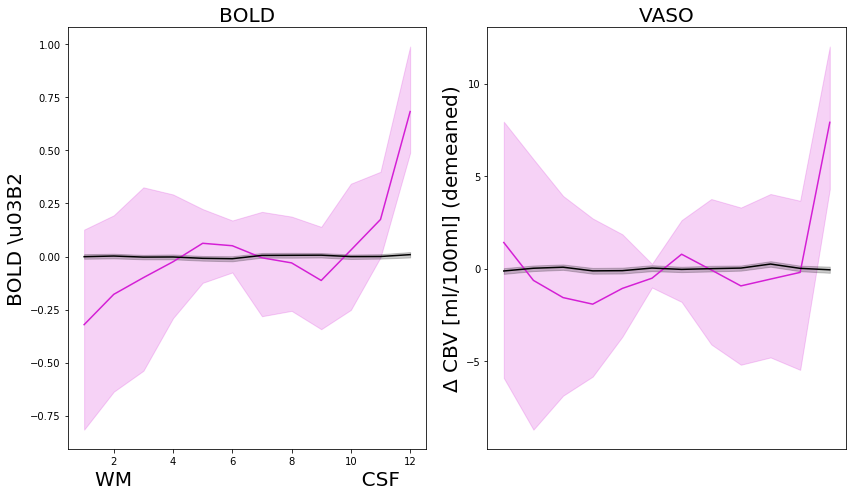

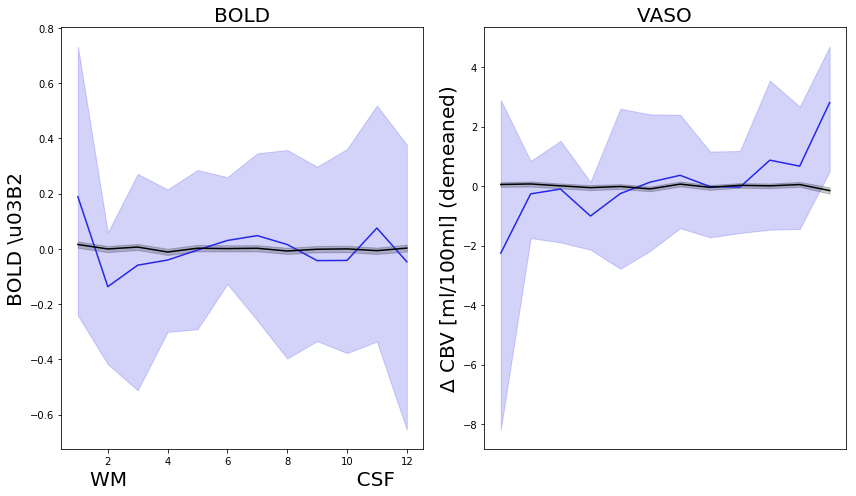

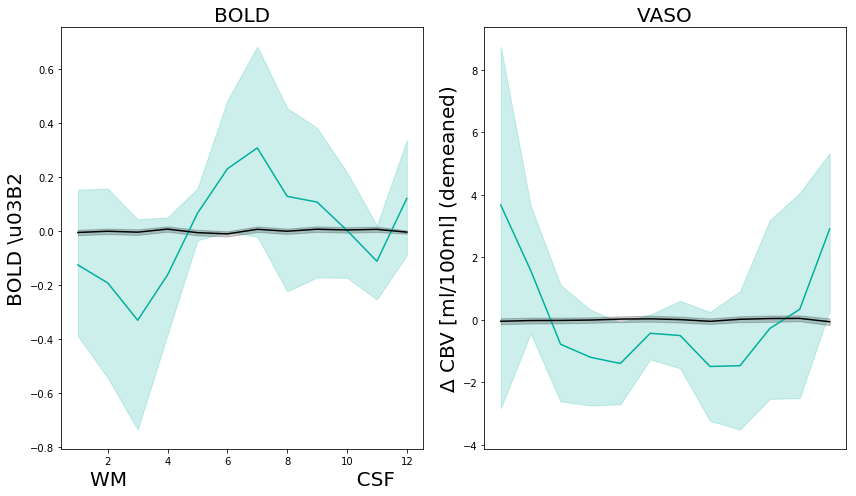

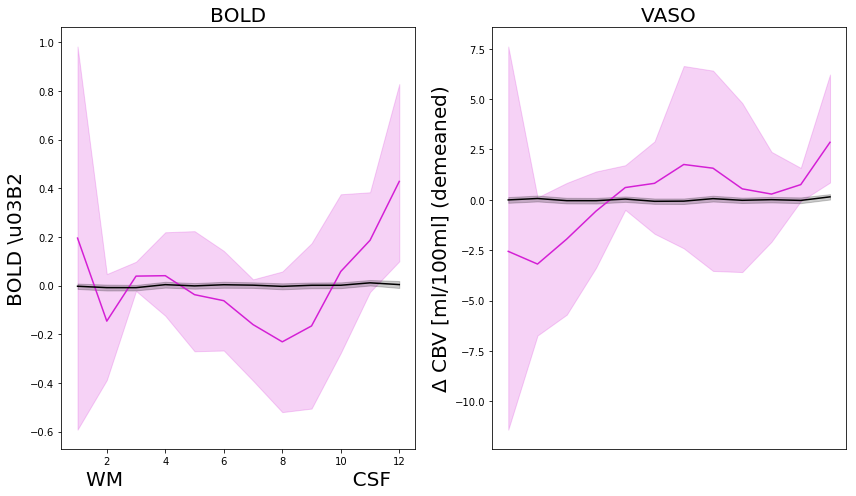

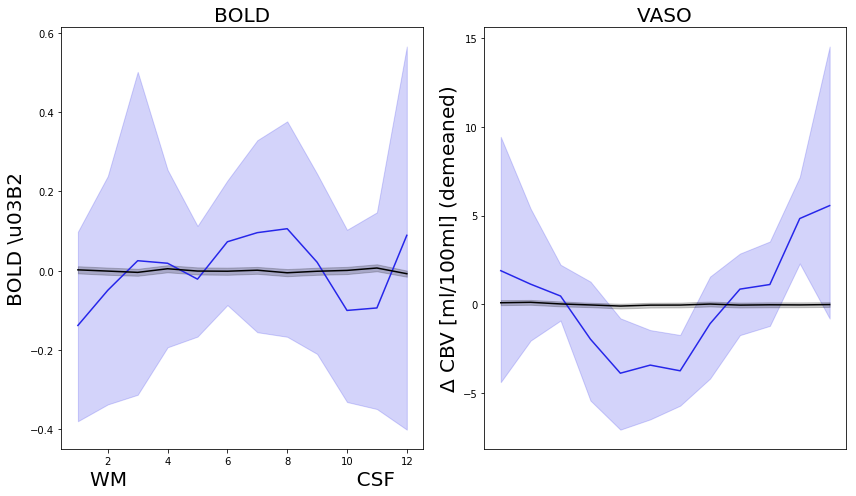

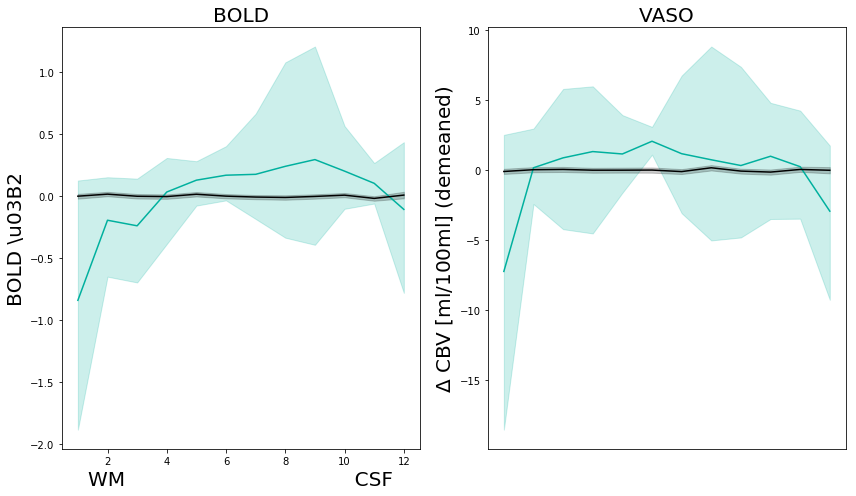

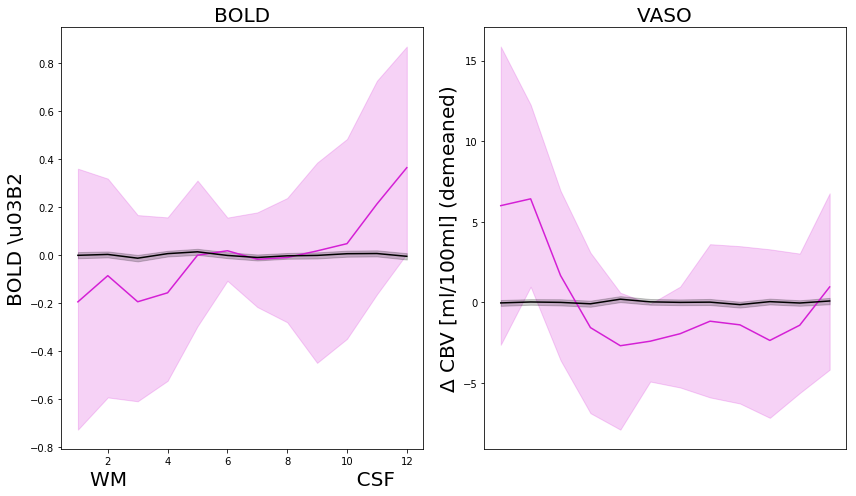

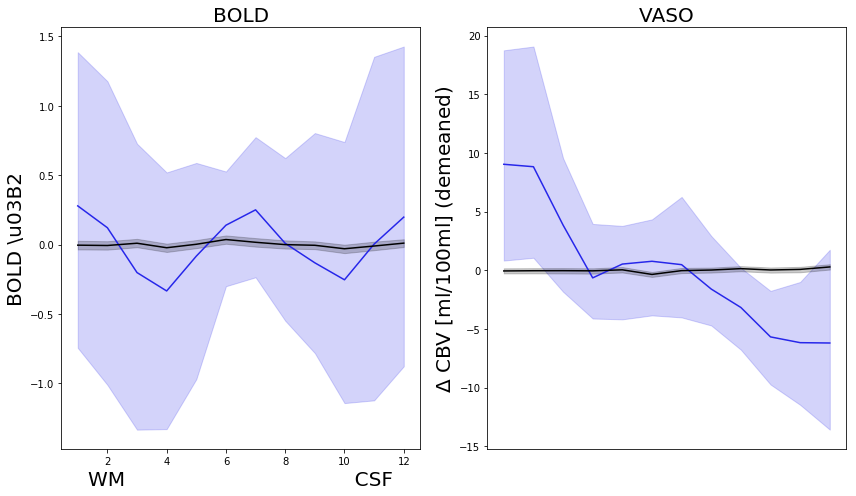

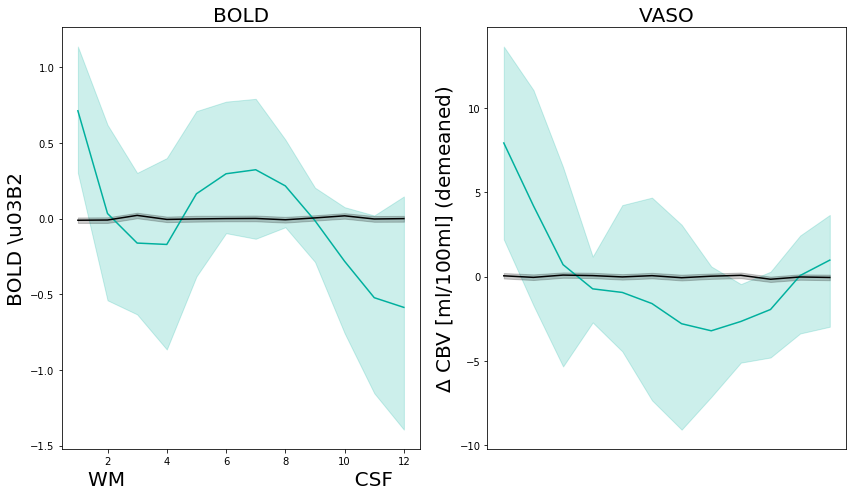

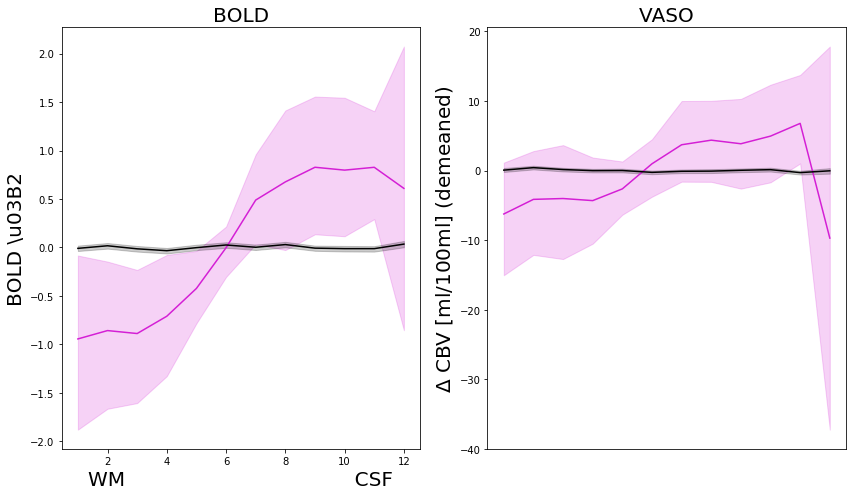

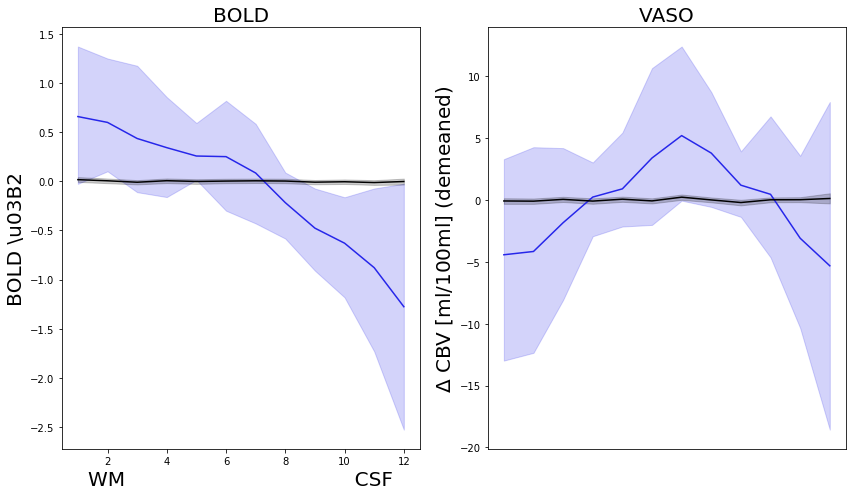

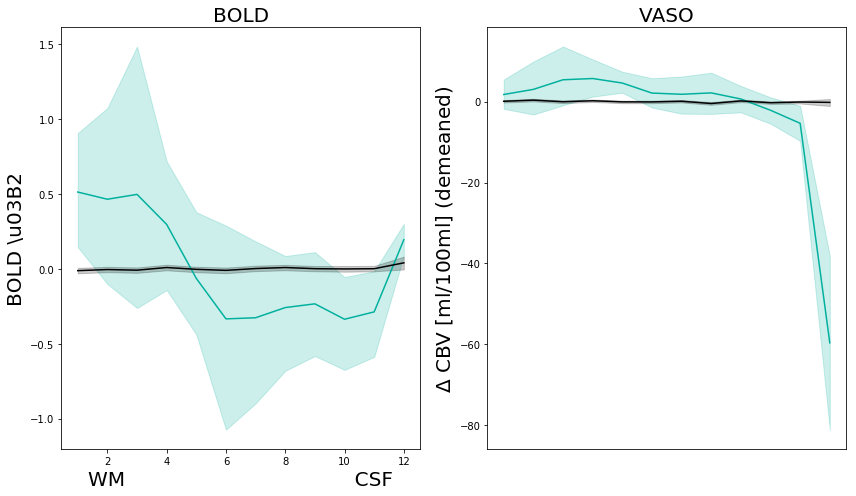

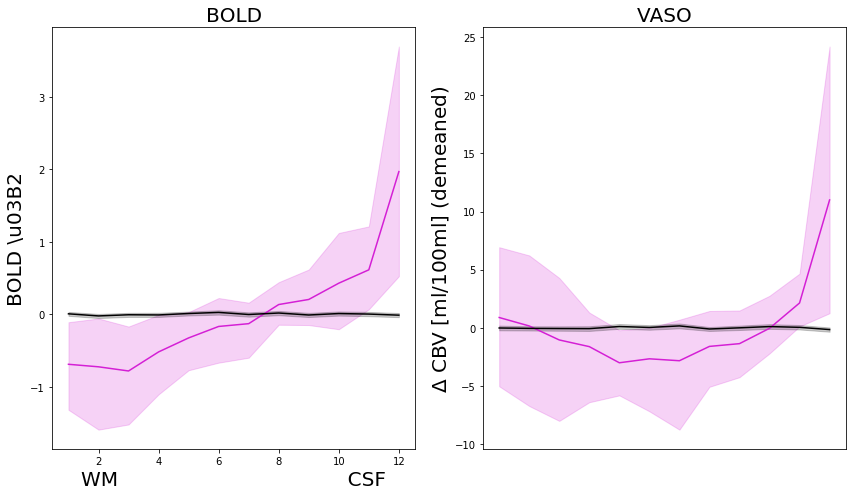

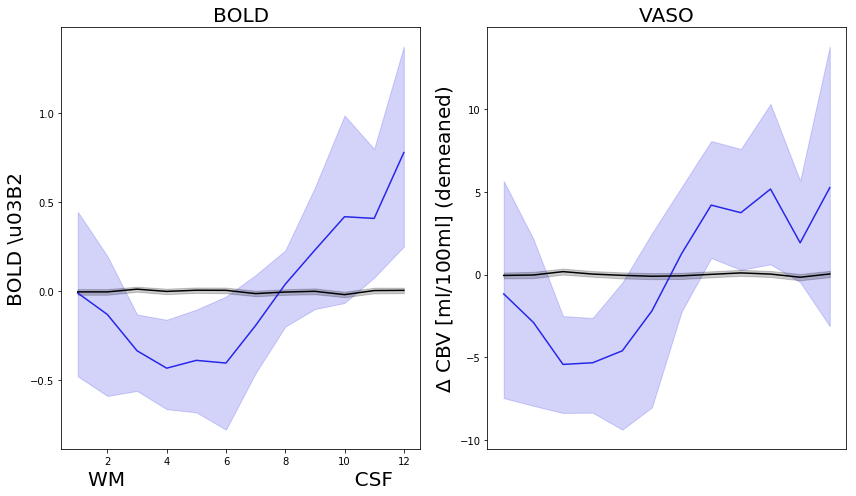

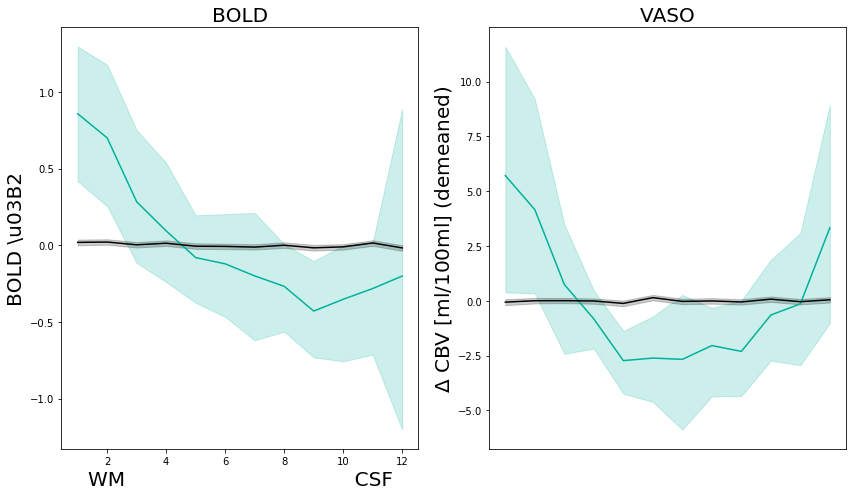

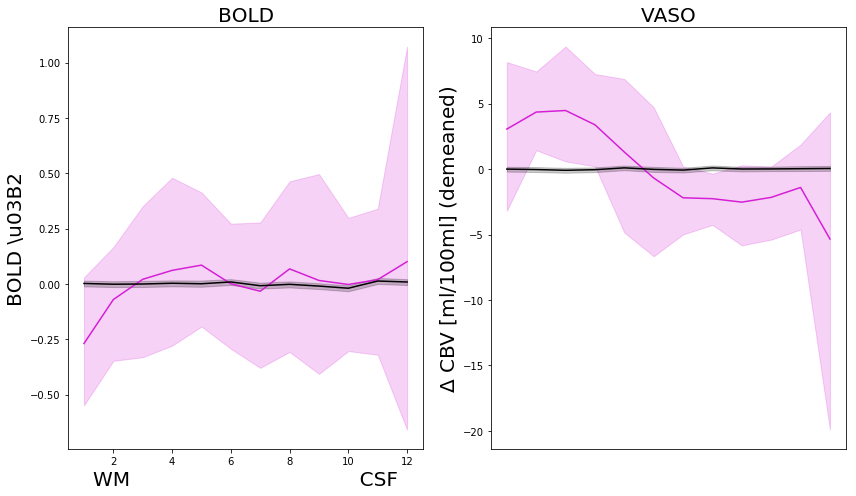

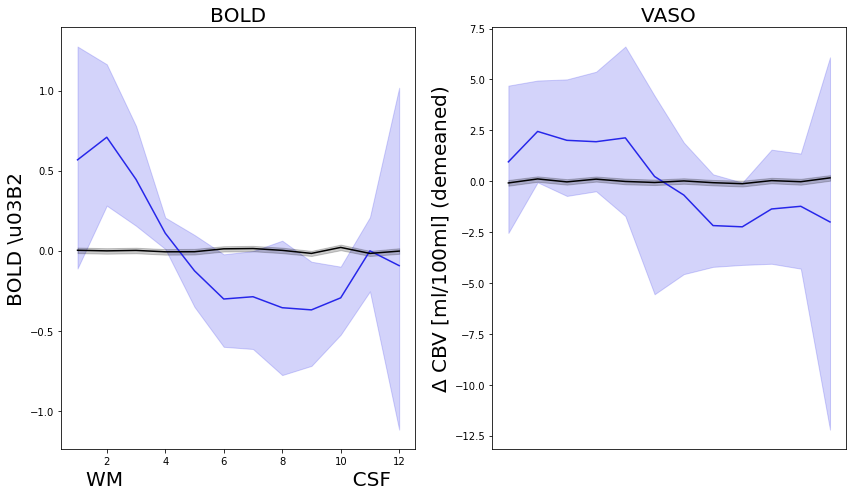

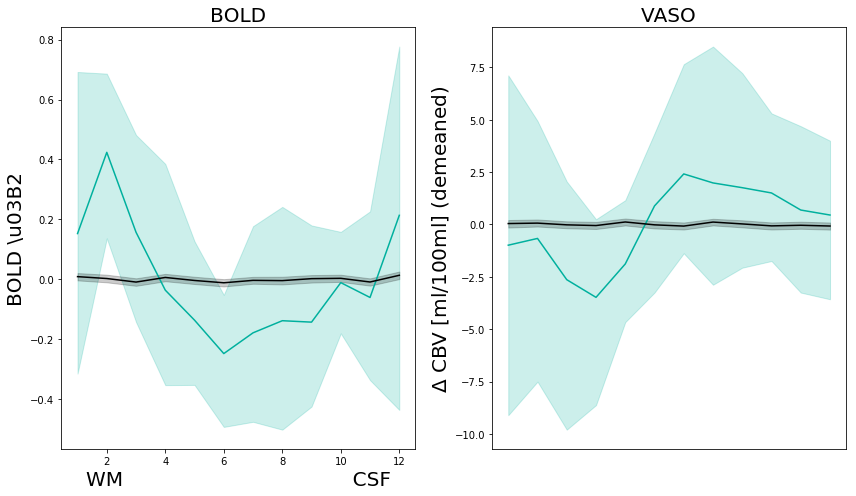

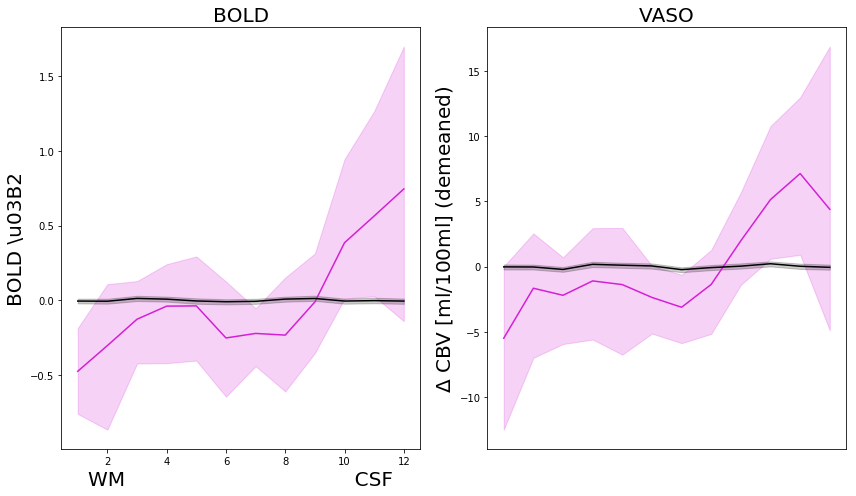

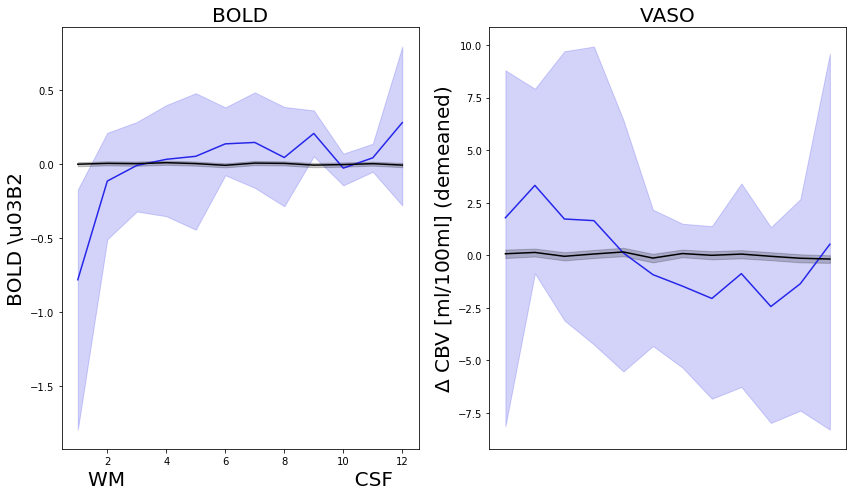

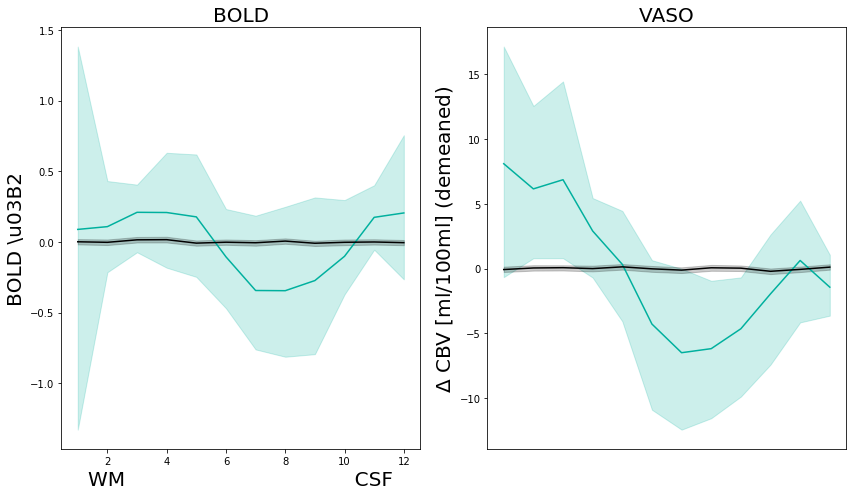

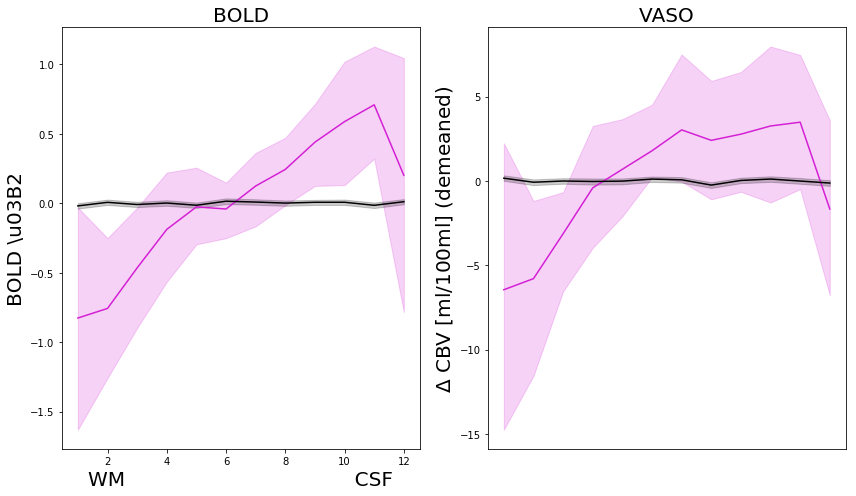

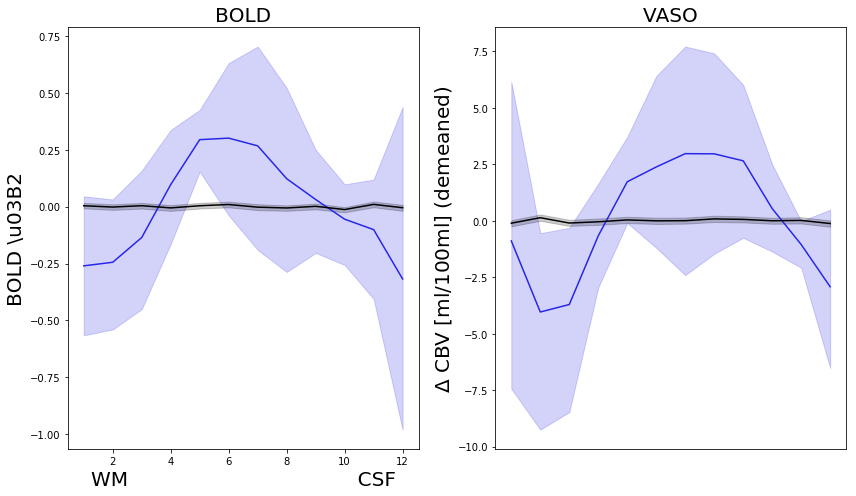

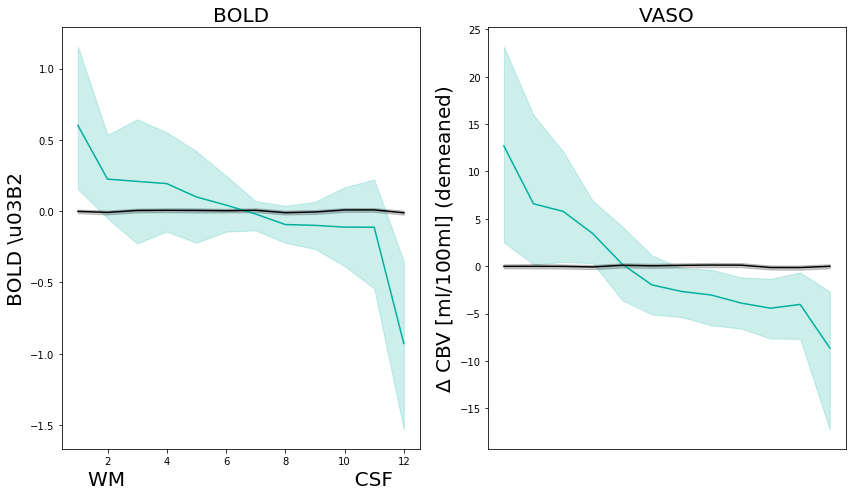

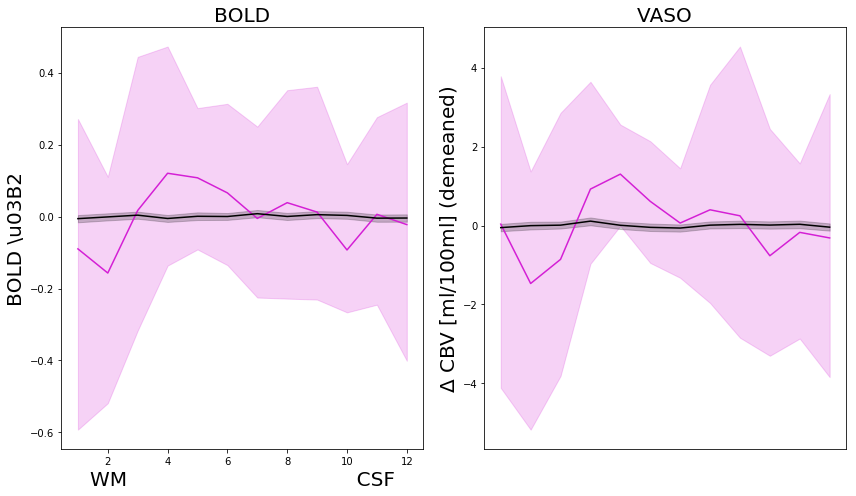

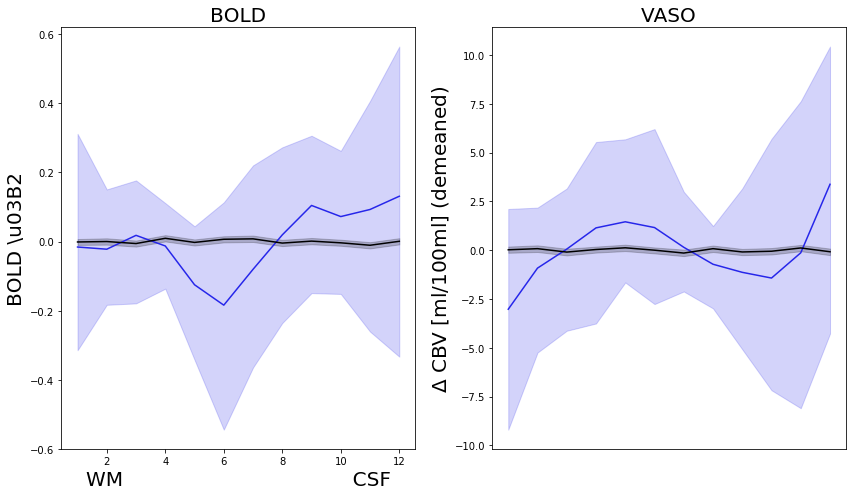

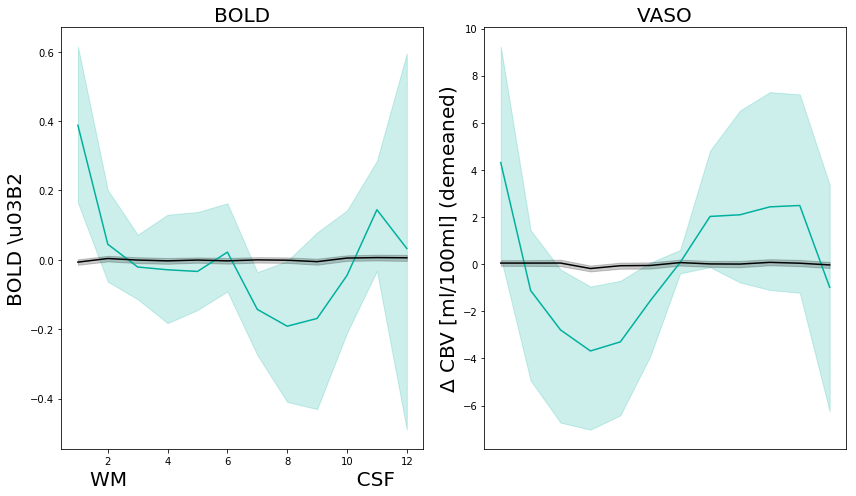

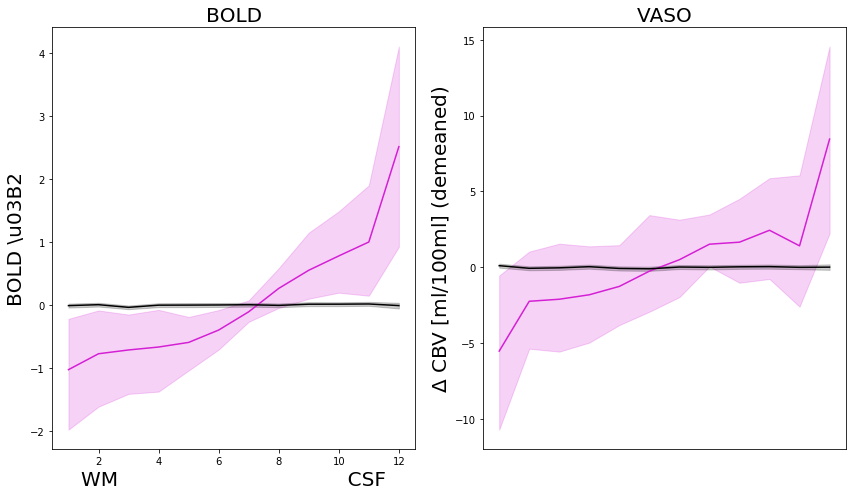

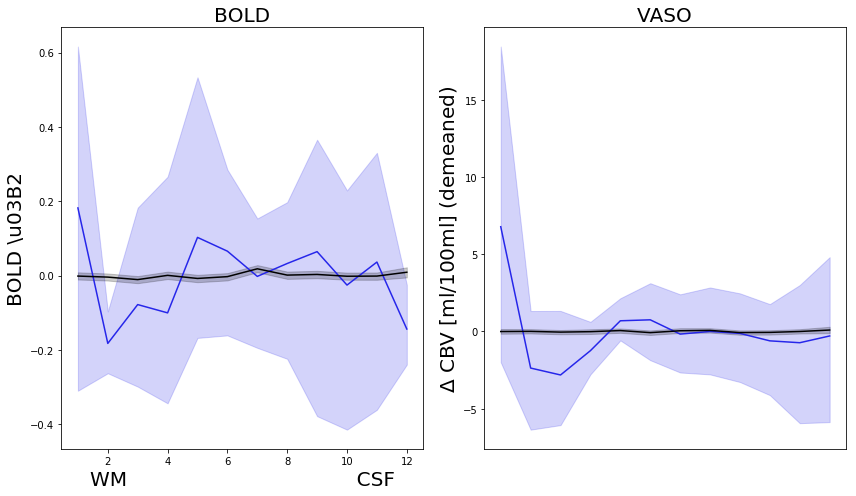

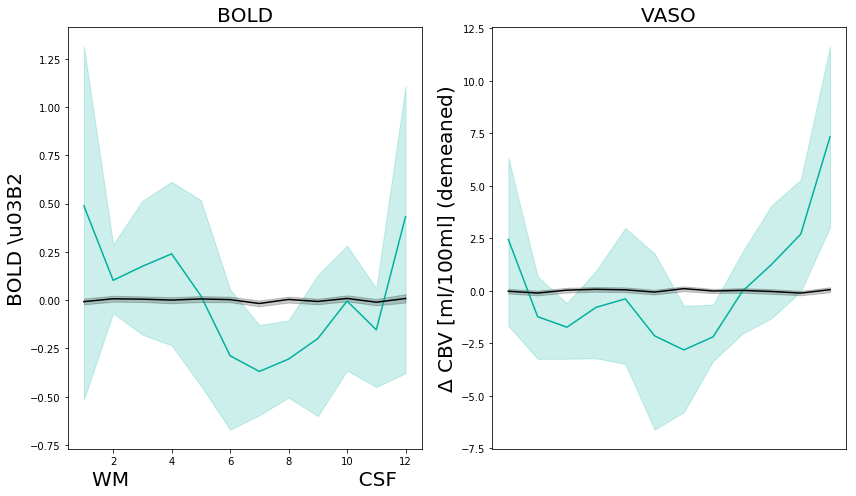

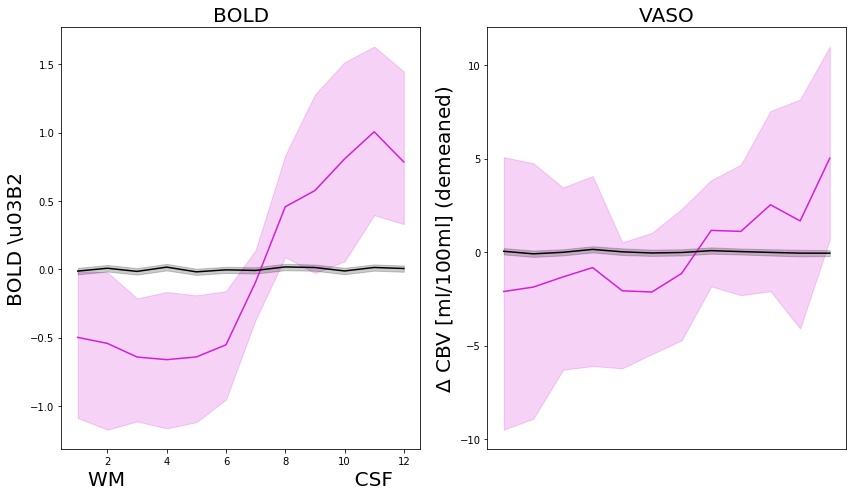

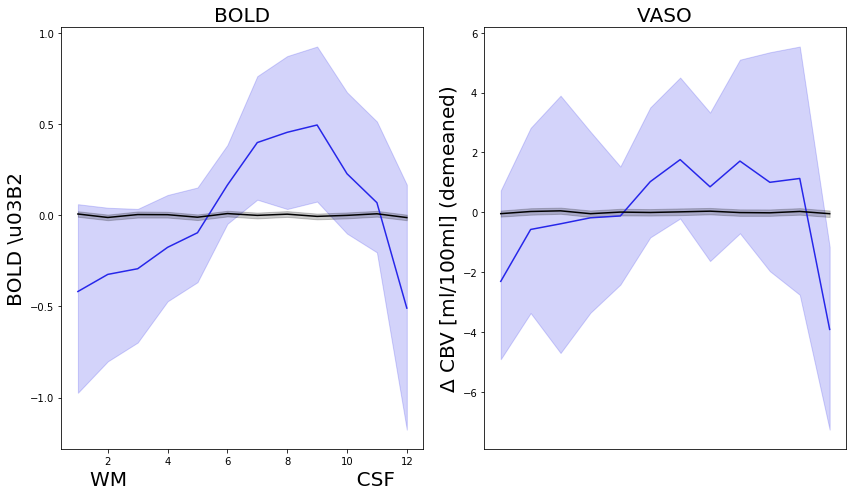

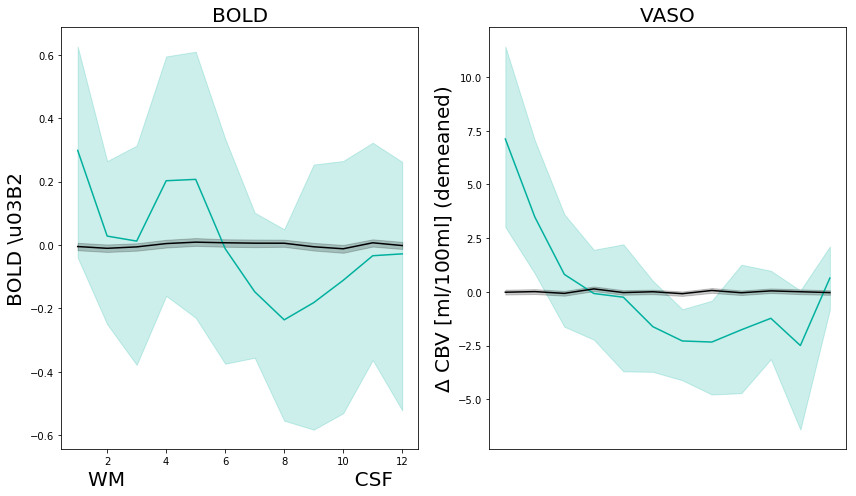

In [875]:
colors=['#00B09E', '#2626EA','#D41FD5']
depths = ['02','06','11']
depths.reverse()
colors.reverse()
seed_labels = ['superficial','middle','deep']



yaxes = [r'BOLD \u03B2', r'$\Delta$ CBV [ml/100ml] (demeaned)']



for sub in subs:
    for depth,seed_label,color in zip(depths,seed_labels,colors):
        fig, axes = plt.subplots(1,2, tight_layout=True,figsize=(12,7))

    #     plt.suptitle('%s seed'%(seed_label), fontsize=25)

        for modality, axis in zip(modalities, [0, 1]):


#             sns.lineplot(ax=axes[axis], data = sub_data.loc[(sub_data['depth']==depth)&(sub_data['modality']==modality)], x='layer', y='layer_val',color=color)
            sns.lineplot(ax=axes[axis], data = sub_data.loc[(sub_data['subject']==sub)&(sub_data['depth']==depth)&(sub_data['modality']==modality)], x='layer', y='layer_val',color=color)

#             sns.lineplot(ax=axes[axis], data = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['modality']==modality)], x='layer', y='layer_val',color='black')
            sns.lineplot(ax=axes[axis], data = permutSub_data.loc[(permutSub_data['subject']==sub)&(permutSub_data['depth']==depth)&(permutSub_data['modality']==modality)], x='layer', y='layer_val',color='black')

            axes[axis].set_ylabel(yaxes[axis],fontsize=20)
            axes[axis].set_title(modality,fontsize=20)


            axes[axis].set_xlabel("WM                                    CSF",fontsize=20)

            plt.xticks([],[])

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



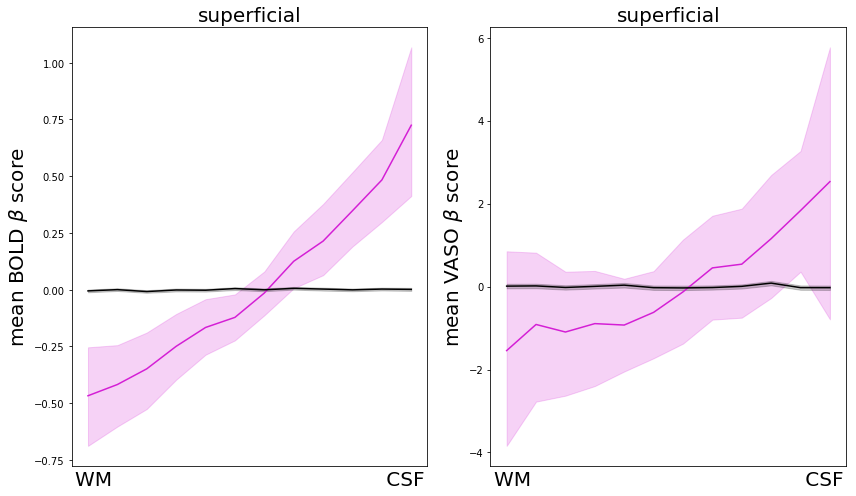

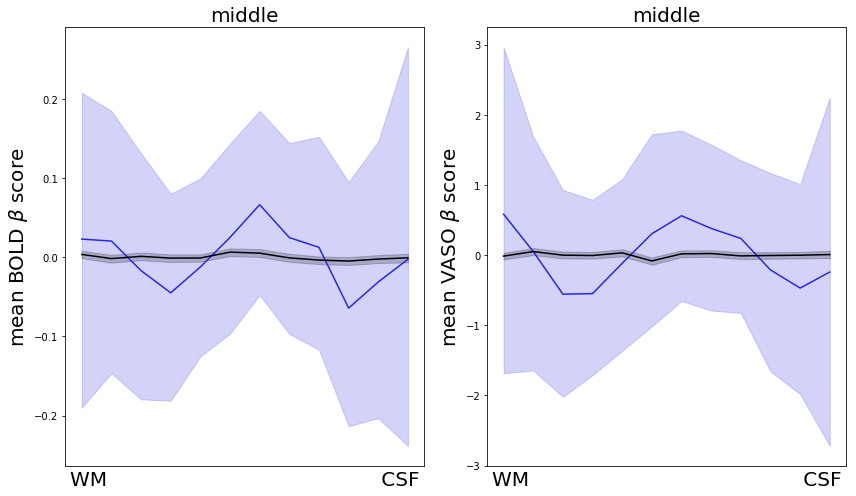

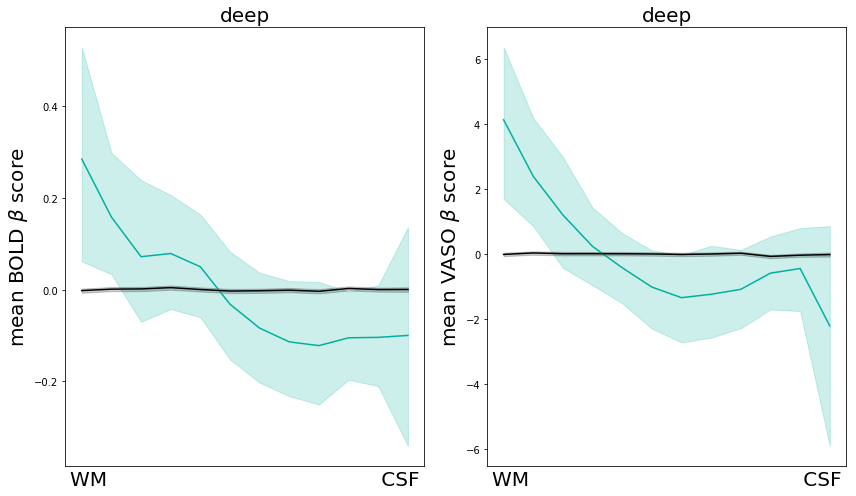

In [884]:
colors=['#00B09E', '#2626EA','#D41FD5']
depths = ['02','06','11']
depths.reverse()
colors.reverse()
seed_labels = ['superficial','middle','deep']



yaxes = [r'BOLD $\beta$', r'$\Delta$ CBV [ml/100ml] (demeaned)']

yaxes = [r'mean BOLD $\beta$ score', r'mean VASO $\beta$ score']

for depth,seed_label,color in zip(depths,seed_labels,colors):
    fig, axes = plt.subplots(1,2, tight_layout=True,figsize=(12,7))

#     plt.suptitle('%s seed'%(seed_label), fontsize=25)

    for modality, axis in zip(modalities, [0, 1]):


        sns.lineplot(ax=axes[axis], data = sub_data.loc[(sub_data['depth']==depth)&(sub_data['modality']==modality)], x='layer', y='layer_val',color=color)
#         sns.lineplot(ax=axes[axis], data = sub_data.loc[(sub_data['subject']==sub)&(sub_data['depth']==depth)&(sub_data['modality']==modality)], x='layer', y='layer_val',color=color)

        sns.lineplot(ax=axes[axis], data = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['modality']==modality)], x='layer', y='layer_val',color='black')
#         sns.lineplot(ax=axes[axis], data = permutSub_data.loc[(permutSub_data['subject']==sub)&(permutSub_data['depth']==depth)&(permutSub_data['modality']==modality)], x='layer', y='layer_val',color='black')

        axes[axis].set_ylabel(yaxes[axis],fontsize=20)
        axes[axis].set_title(seed_label,fontsize=20)


        axes[axis].set_xlabel("WM                                           CSF",fontsize=20)

        axes[axis].set_xticks([],[])
        
        
    plt.savefig(f'/home/sebastian/Desktop/{seed_label}.png')

## Permute over columns

In order to estimate the connectivity between our finger ROIs, we have to establish a baseline. We will do this through permutation testing. For this, we define columns using LN2_COLUMNS in LayNii. Additinal care will be taken that the column size matches the size of oour actual ROIs.

### Define columns and match size

We want to match our column size with size of our ROIs. Unfortunately, setting a column size is not possible in LayNii. Therefore, we will go thorugh some iterations.

In [7]:
digits = ['D2', 'D3', 'D4']

In [14]:
substmp[1:2]

['sub-15']

sub-18
Our mean ROI size is: 373.3333333333333 voxels
testing 1000 columns
Our current average column size is: 388.45 voxels


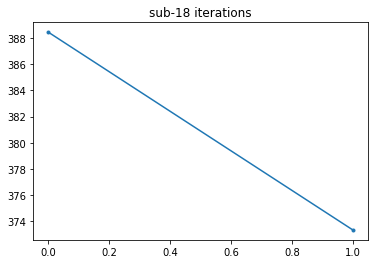

In [245]:
for sub in ['sub-18']:
    
    print(sub)
    
    # find roi voxel count
    roiVoxels = []
    for digit in digits:
        mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        nonZero = np.count_nonzero(mask)
        roiVoxels.append(nonZero)
    meanCountDigits = np.mean(np.array(roiVoxels))
    
    print(f'Our mean ROI size is: {meanCountDigits} voxels')
    
    upperLim = meanCountDigits + ((meanCountDigits/100)*10)
    lowerLim = meanCountDigits - ((meanCountDigits/100)*10)
    
    meanCount = 0
    
    iterations = []
    
    columnCount = 1000

    
    os.system(f'mkdir -p {root}/derivatives/{sub}/anat/findColSize/iterate')
    
    while meanCount > upperLim or meanCount < lowerLim:
        print(f'testing {columnCount} columns')
        
        os.system(f'LN2_COLUMNS -rim {root}/derivatives/{sub}/anat/{sub}_rim.nii.gz -midgm {root}/derivatives/{sub}/anat/{sub}_rim_midGM_equidist.nii.gz -nr_columns {columnCount} -output {root}/derivatives/{sub}/anat/findColSize/iterate/{sub}')

        cols = nb.load(f'{root}/derivatives/{sub}/anat/findColSize/iterate/{sub}_columns{columnCount}.nii').get_fdata()

        voxelCounts = []

        for column in np.unique(cols)[1:]:

            roi = cols == column
            nonZero = np.count_nonzero(roi)
            voxelCounts.append(nonZero)

        meanCount = np.mean(np.array(voxelCounts))
        
        iterations.append(meanCount)
        
        print(f'Our current average column size is: {meanCount} voxels')
        
        # if the average column has more voxels than our predefined count, we have to increase the number of columns
        # to make the voxel number smaller
        if meanCount > upperLim:
            columnCount = columnCount + 20
        # the opposite is true if the average column has less voxels than our ROIs    
        if meanCount < lowerLim:
            columnCount = columnCount - 20
            
    
    iterations.append(meanCountDigits)
    plt.figure()
    plt.plot(iterations, marker='.')
    plt.title(f'{sub} iterations')
    plt.show()
    os.system(f'LN2_COLUMNS -rim {root}/derivatives/{sub}/anat/{sub}_rim.nii.gz -midgm {root}/derivatives/{sub}/anat/{sub}_rim_midGM_equidist.nii.gz -nr_columns {columnCount} -output {root}/derivatives/{sub}/anat/findColSize/{sub}')
    os.system(f'rm -r {root}/derivatives/{sub}/anat/findColSize/iterate')

    
    

### Timecourse extraction from ROIs

To speed up the process of timecourse extraction, we truncate the timeseries to the box surrounding our ROIs.

This still takes a lot of time. Therefore, we will test a few options.

1. extracting information from all columns at the same time.

In [210]:
import time

In [282]:
start_time = time.time()



for sub in subs[1:]:
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_column*.nii')[0]
    cols = nb.load(colFile).get_fdata()

    idx_columns = np.unique(cols)[1:].astype("int")



#     colRoi = cols != 0
#     colBox = find_roi_box(colRoi)

#     colsArr = np.asarray(nb.load(colFile).dataobj[colBox[0], colBox[1], colBox[2]])



    layers3 = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_3_layers_equivol.nii').get_fdata()
    nrlayers3 = len(np.unique(layers)[1:])


#     layersFile3 = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_3_layers_equivol.nii')
#     laysArr3 = np.asarray(layersFile.dataobj[colBox[0], colBox[1], colBox[2]])


    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))
    base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
    print(base)

    # find number of columns
    nrColumns = len(idx_columns)

    for modality in ['VASO', 'BOLD']:
#     for modality in ['VASO']:
        print(f'processing {modality}...')

        timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
        timecourse03 = np.zeros((nrColumns, timepoints, nrlayers3))


        for n in range(0, timepoints):
            data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
#             dataArr = np.asarray(data.dataobj[colBox[0], colBox[1], colBox[2]])
            dataArr = data.get_fdata()

            for column in idx_columns:
#                 print(f'processing column {column}')
                tmpCol = (cols == column).astype(int)


                for layer in np.unique(layers3)[1:]:
#                     print(f"layer {layer}")
                    tmpLayer = (layers3 == layer).astype(int)
                    intersection = np.multiply(tmpCol, tmpLayer).astype("float")
        

                    idxIntersection = intersection == 1


                    mask_mean = np.mean(dataArr[idxIntersection])
#                     print(mask_mean)

                    timecourse03[int(column)-1, n, int(layer)-1] = mask_mean
    

    
    
        print('saving...')
        for column in idx_columns:
            for layer in np.unique(layers3)[1:]:
                np.savetxt(f'{root}/derivatives/{sub}/func/timecourses/{base}_{modality}_col{int(column):03d}_03layers_layer{int(layer):02d}_timecourse.txt', timecourse03[int(column)-1, :, int(layer)-1], delimiter='/n', fmt='%1.4f')


endTime = time.time()
print("--- %s seconds ---" % (endTime - start_time))


sub-02_ses-003_task-restBA3b_run-001
processing VASO...
saving...
processing BOLD...
saving...
--- 117300.82975459099 seconds ---


In [276]:

ni_img = nb.Nifti1Image(tmpCol, nb.load(colFile).affine)
nb.save(ni_img, f'{root}/derivatives/sub-02/anat/findColSize/sub-02_col{column}.nii')

the absolute time takefn for one modality will be 

In [253]:
timeTaken = (endTime - start_time)
print("--- %s minutes ---" % (timeTaken/60))

--- 3.361095607280731 minutes ---


In [254]:
((3.361)*timepoints)/60

35.2905

In [ ]:
313/60

In [259]:
timecourse

array([[89.06640625, 84.78571429, 84.28571429],
       [88.73046875, 85.08928571, 84.71428571],
       [89.02734375, 88.01785714, 86.71428571],
       ...,
       [85.99609375, 91.26785714, 91.        ],
       [82.90234375, 90.14285714, 93.42857143],
       [82.80859375, 86.05357143, 90.71428571]])

2. extracting from a column at a time

In [262]:
start_time = time.time()

for sub in subs:
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_column*.nii')[0]
    cols = nb.load(colFile).get_fdata()
    
    idx_columns = np.unique(cols)[1:].astype("int")

    layers = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_3_layers_equivol.nii').get_fdata()
    nrlayers = len(np.unique(layers)[1:])

    

    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))
    base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    
    for column in idx_columns[0:1]:
        print(f'processing column {column}')
        tmpCol = (cols == column).astype(int)


        colRoi = cols == column

        box = find_roi_box(colRoi)


        colRoiTrunc = colRoi[box[0], box[1], box[2]]
#         for modality in ['VASO', 'BOLD']:
        for modality in ['VASO', 'BOLD']:

            timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
            timecourse = np.zeros((timepoints, nrlayers))


            for n in range(0, timepoints):
                data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
                dataArr = np.asarray(data.dataobj[box[0], box[1], box[2]])


                for layer in np.unique(layers)[1:]:
    #                 print(f"layer {layer}")
                    tmpLayer = (layers == layer).astype(int)
                    intersection = np.multiply(tmpCol, tmpLayer).astype("float")

                    idxIntersection = intersection == 1

                    idxIntersectionTrunc = idxIntersection[box[0], box[1], box[2]]

                    mask_mean = np.mean(dataArr[idxIntersectionTrunc])
    #                 print(mask_mean)

                    timecourse[n, int(layer)-1] = mask_mean

            for layer in np.unique(layers)[1:]:
    #             print(layer)
                np.savetxt(f'{root}/derivatives/{sub}/func/timecourses/{base}_{modality}_col{int(column):03d}_layer{int(layer):02d}_timecourse2.txt', timecourse[:,int(layer)-1], delimiter='/n', fmt='%1.4f')
        endTime = time.time()
        print("--- %s seconds ---" % (endTime - start_time))


sub-18_ses-001_task-restBA3b_run-001
processing column 1
--- 5.762841463088989 seconds ---


In [256]:
timeTaken = (endTime - start_time)
print("--- %s minutes ---" % (timeTaken/60))

--- 2.250413664182027 minutes ---


In [258]:
((timeTaken/60)*len(idx_columns))/60

37.50689440303379

In [260]:
for layer in np.unique(layers)[1:]:
#             print(layer)
    np.savetxt(f'{root}/derivatives/{sub}/func/timecourses/{base}_{modality}_col{int(column):03d}_layer{int(layer):02d}_timecourse.txt', timecourse[:,int(layer)-1], delimiter='/n', fmt='%1.4f')


The approach above might be error prone. Therefore, we will test for one column whether our code gives us the same results as a conventional approach. The likelyhood that the results are simlar by chance is very low.

In [945]:
colNii = nb.load(f'{root}/derivatives/sub-15/anat/findColSize/sub-15_columns300.nii')
colAff = colNii.affine
colData =colNii.get_fdata()
col1 = (colData == 1).astype(int)

layNii = nb.load(f'{root}/derivatives/sub-15/anat/sub-15_3_layers_equivol.nii')
layData =layNii.get_fdata()
lay1 = (layData == 1).astype(int)

intersection = np.multiply(col1, lay1).astype("float")

ni_img = nb.Nifti1Image(intersection, colAff)
nb.save(ni_img, f'{root}/derivatives/sub-15/anat/findColSize/sub-15_intersect.nii')

In [947]:
timepoints = nb.load(f'{root}/derivatives/sub-15/func/sub-15_ses-001_task-restBA3b_run-001_VASO.nii.gz').get_fdata().shape[-1]

os.system(f'3dmaskave -quiet -mask {root}/derivatives/sub-15/anat/findColSize/sub-15_intersect.nii {root}/derivatives/sub-15/func/scaledVolumes/sub-15_ses-001_task-restBA3b_run-001_VASO_vol_1000_scaled.nii > {root}/derivatives/sub-15/anat/findColSize/test.txt')

for n in range(1, timepoints):
    os.system(f'3dmaskave -quiet -mask {root}/derivatives/sub-15/anat/findColSize/sub-15_intersect.nii {root}/derivatives/sub-15/func/scaledVolumes/sub-15_ses-001_task-restBA3b_run-001_VASO_vol_{n+1000}_scaled.nii >> {root}/derivatives/sub-15/anat/findColSize/test.txt')


In [948]:
test = np.loadtxt(f'{root}/derivatives/sub-15/anat/findColSize/test.txt', delimiter='\n')
actual = np.loadtxt(f'{root}/derivatives/sub-15/func/timecourses/sub-15_ses-001_task-restBA3b_run-001_VASO_col001_layer01_timecourse.txt', delimiter='\n')

In [949]:
test == actual

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Cool, this checks out. Let's continue with the permutation testing.

### Actual permutation

We start by creating an array that contains all column numbers. From this we will draw a triplet in each iteration.

In [958]:
columnNrs = np.arange(1,301)

Then, we can set the number of iterations we want to do.

In [950]:
nrPermutations = 10

And here we go

In [160]:
for sub in subs:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]



    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)

    roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
    allRois = np.zeros(roi.shape)


    for digit in digits:
        roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        allRois = np.add(allRois, roi)

    allRois = (allRois>0).astype(int)


    box = find_roi_box(allRois)

    for modality in modalities:

        timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
        data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_1000_scaled.nii')
        dataArr = data.get_fdata()[box[0], box[1], box[2]]
        newData = np.zeros((dataArr.shape[0],dataArr.shape[1],dataArr.shape[2],timepoints))    
        affine = data.affine


        for n in range(0, timepoints):
            vol = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii').get_fdata()[box[0], box[1], box[2]]
            newData[:,:,:,n] = vol

        ni_img = nb.Nifti1Image(newData[:,:,:,:-1], affine)
        nb.save(ni_img, f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii')

sub-02_ses-003_task-restBA3b_run-001
sub-05_ses-002_task-restBA3b_run-001
sub-06_ses-001_task-restBA3b_run-001
sub-07_ses-001_task-restBA3b_run-001
sub-09_ses-001_task-restBA3b_run-001
sub-10_ses-001_task-restBA3b_run-001
sub-12_ses-001_task-restBA3b_run-001
sub-15_ses-001_task-restBA3b_run-001
sub-16_ses-001_task-restBA3b_run-001
sub-17_ses-001_task-restBA3b_run-001
sub-18_ses-001_task-restBA3b_run-001


In [161]:
for sub in subs:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]



    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)


    for modality in modalities:

        data = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'
        
        os.system(f'3drefit -TR 1.9295 {data}')

sub-02_ses-003_task-restBA3b_run-001
sub-05_ses-002_task-restBA3b_run-001
sub-06_ses-001_task-restBA3b_run-001
sub-07_ses-001_task-restBA3b_run-001
sub-09_ses-001_task-restBA3b_run-001
sub-10_ses-001_task-restBA3b_run-001
sub-12_ses-001_task-restBA3b_run-001
sub-15_ses-001_task-restBA3b_run-001
sub-16_ses-001_task-restBA3b_run-001
sub-17_ses-001_task-restBA3b_run-001
sub-18_ses-001_task-restBA3b_run-001


In [197]:
# Set this to the directory all of the sub### directories live in
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'


fsfDir = f"{root}/derivatives/designFiles/fsfs"

for sub in subs:
    
    for modality in ['BOLD', 'VASO']:
        print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
                    
            
            actualData = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            
            print(nrVolumes)

            replacements = {'SUB': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': nrVolumes}



            with open(f"{fsfDir}/restingStateDesignTemplate.fsf") as infile:
                with open(f"{fsfDir}/{base}_{modality}.fsf", 'w') as outfile:
                    for line in infile:
                        for src, target in replacements.items():
                            line = line.replace(src, target)
                        outfile.write(line)

  

BOLD
sub-02_ses-003_task-restBA3b_run-001
651
VASO
sub-02_ses-003_task-restBA3b_run-001
651
BOLD
sub-05_ses-002_task-restBA3b_run-001
331
VASO
sub-05_ses-002_task-restBA3b_run-001
331
BOLD
sub-06_ses-001_task-restBA3b_run-001
317
VASO
sub-06_ses-001_task-restBA3b_run-001
317
BOLD
sub-07_ses-001_task-restBA3b_run-001
331
VASO
sub-07_ses-001_task-restBA3b_run-001
331
BOLD
sub-09_ses-001_task-restBA3b_run-001
331
VASO
sub-09_ses-001_task-restBA3b_run-001
331
BOLD
sub-10_ses-001_task-restBA3b_run-001
331
VASO
sub-10_ses-001_task-restBA3b_run-001
331
BOLD
sub-12_ses-001_task-restBA3b_run-001
331
VASO
sub-12_ses-001_task-restBA3b_run-001
329
BOLD
sub-15_ses-001_task-restBA3b_run-001
685
VASO
sub-15_ses-001_task-restBA3b_run-001
685
BOLD
sub-16_ses-001_task-restBA3b_run-001
621
VASO
sub-16_ses-001_task-restBA3b_run-001
619
BOLD
sub-17_ses-001_task-restBA3b_run-001
619
VASO
sub-17_ses-001_task-restBA3b_run-001
617
BOLD
sub-18_ses-001_task-restBA3b_run-001
631
VASO
sub-18_ses-001_task-restBA3b_

In [202]:
for sub in subs:
    
    for modality in ['BOLD', 'VASO']:
        print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
                    
            
            actualData = f'{root}/derivatives/{sub}/func/{base}_{modality}_scaled.nii'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            
            mergedConfs = np.loadtxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_mergedConfounds.txt')
            
            mergedConfs = mergedConfs[:-1, :]
            np.savetxt(f'{root}/derivatives/{sub}/func/confoundRegressors/{base}_{modality}_mergedConfounds.txt', mergedConfs, delimiter=' ')

BOLD
sub-02_ses-003_task-restBA3b_run-001
VASO
sub-02_ses-003_task-restBA3b_run-001
BOLD
sub-05_ses-002_task-restBA3b_run-001
VASO
sub-05_ses-002_task-restBA3b_run-001
BOLD
sub-06_ses-001_task-restBA3b_run-001
VASO
sub-06_ses-001_task-restBA3b_run-001
BOLD
sub-07_ses-001_task-restBA3b_run-001
VASO
sub-07_ses-001_task-restBA3b_run-001
BOLD
sub-09_ses-001_task-restBA3b_run-001
VASO
sub-09_ses-001_task-restBA3b_run-001
BOLD
sub-10_ses-001_task-restBA3b_run-001
VASO
sub-10_ses-001_task-restBA3b_run-001
BOLD
sub-12_ses-001_task-restBA3b_run-001
VASO
sub-12_ses-001_task-restBA3b_run-001
BOLD
sub-15_ses-001_task-restBA3b_run-001
VASO
sub-15_ses-001_task-restBA3b_run-001
BOLD
sub-16_ses-001_task-restBA3b_run-001
VASO
sub-16_ses-001_task-restBA3b_run-001
BOLD
sub-17_ses-001_task-restBA3b_run-001
VASO
sub-17_ses-001_task-restBA3b_run-001
BOLD
sub-18_ses-001_task-restBA3b_run-001
VASO
sub-18_ses-001_task-restBA3b_run-001


In [203]:
for sub in subs[1:]:
    feats = sorted(glob.glob(f'{fsfDir}/{sub}_*rest*.fsf'))
    for feat1, feat2 in zip(feats[::2],feats[1::2]):
        print(f'1: {feat1}')
        print(f'2: {feat2}')
        os.system(f'feat {feat1} & feat {feat2}')

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-05_ses-002_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-05_ses-002_task-restBA3b_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-06_ses-001_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-06_ses-001_task-restBA3b_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-07_ses-001_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-07_ses-001_task-restBA3b_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-09_ses-001_task-restBA3b_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/der

In [431]:
sub_list=[]
seed_rois=[]
read_rois=[]
layer_val=[]
layerNr=[]
seedDepths_list=[]
modalityList = []



mappingDict = {'1': {'digit': 'D2', 'seedLayer': 1},
              '2': {'digit': 'D2', 'seedLayer': 2},
              '3': {'digit': 'D2', 'seedLayer': 3},
              '4': {'digit': 'D3', 'seedLayer': 1},
              '5': {'digit': 'D3', 'seedLayer': 2},
              '6': {'digit': 'D3', 'seedLayer': 3},
              '7': {'digit': 'D4', 'seedLayer': 1},
              '8': {'digit': 'D4', 'seedLayer': 2},
              '9': {'digit': 'D4', 'seedLayer': 3},}

for sub in subs:
    print(sub)
    roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_D2_3_layers_equivol.nii').get_fdata()
    allRois = np.zeros(roi.shape)


    for digit in digits:
        roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{digit}_3_layers_equivol.nii').get_fdata()
        allRois = np.add(allRois, roi)

    allRois = (allRois>0).astype(int)


    box = find_roi_box(allRois)
    
    
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))



    base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    for modality in modalities:

        for pe in range(1,10):
            seedDigit = mappingDict[str(pe)]['digit']
            seedLayer = mappingDict[str(pe)]['seedLayer']
            print(f'Seed: {seedDigit} layer {seedLayer}')

            nonseeds = digits.copy()
            nonseeds.remove(seedDigit)

            resultsMap = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/pe{pe}.nii.gz').get_fdata()

            for readROI in nonseeds:
                print(f'read from: {readROI}')

                roi = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{readROI}_12_layers_equivol.nii').get_fdata()[box[0], box[1], box[2]]

                profile = []

                for layer in np.unique(roi)[1:]:

                    layerRoi = roi == layer

                    mask_mean = np.mean(resultsMap[layerRoi])
                    profile.append(mask_mean)

                arr = np.array(profile)
                arr = arr-np.mean(arr)

                for n, val in enumerate(arr):                
                    layer_val.append(float(np.copy(val)))
                    layerNr.append(n+1)
                    seed_rois.append(str(seedDigit))
                    read_rois.append(str(readROI))
                    sub_list.append(sub)
                    seedDepths_list.append("%02d" % (int(seedLayer),))
                    modalityList.append(modality)
                    
                    
                    
sub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth','modality'])
sub_data['subject']=sub_list
sub_data['seed_roi']=seed_rois
sub_data['read_roi']=read_rois
sub_data['layer']=layerNr
sub_data['layer_val']=layer_val
sub_data['depth']=seedDepths_list
sub_data['modality']=modalityList

sub-02
sub-02_ses-003_task-restBA3b_run-001
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 layer 3
read from: D3
read from: D4
Seed: D3 layer 1
read from: D2
read from: D4
Seed: D3 layer 2
read from: D2
read from: D4
Seed: D3 layer 3
read from: D2
read from: D4
Seed: D4 layer 1
read from: D2
read from: D3
Seed: D4 layer 2
read from: D2
read from: D3
Seed: D4 layer 3
read from: D2
read from: D3
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 layer 3
read from: D3
read from: D4
Seed: D3 layer 1
read from: D2
read from: D4
Seed: D3 layer 2
read from: D2
read from: D4
Seed: D3 layer 3
read from: D2
read from: D4
Seed: D4 layer 1
read from: D2
read from: D3
Seed: D4 layer 2
read from: D2
read from: D3
Seed: D4 layer 3
read from: D2
read from: D3
sub-05
sub-05_ses-002_task-restBA3b_run-001
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 lay

sub-18_ses-001_task-restBA3b_run-001
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 layer 3
read from: D3
read from: D4
Seed: D3 layer 1
read from: D2
read from: D4
Seed: D3 layer 2
read from: D2
read from: D4
Seed: D3 layer 3
read from: D2
read from: D4
Seed: D4 layer 1
read from: D2
read from: D3
Seed: D4 layer 2
read from: D2
read from: D3
Seed: D4 layer 3
read from: D2
read from: D3
Seed: D2 layer 1
read from: D3
read from: D4
Seed: D2 layer 2
read from: D3
read from: D4
Seed: D2 layer 3
read from: D3
read from: D4
Seed: D3 layer 1
read from: D2
read from: D4
Seed: D3 layer 2
read from: D2
read from: D4
Seed: D3 layer 3
read from: D2
read from: D4
Seed: D4 layer 1
read from: D2
read from: D3
Seed: D4 layer 2
read from: D2
read from: D3
Seed: D4 layer 3
read from: D2
read from: D3


## permuting across layers

This is an exploratory part where I want to see whether i can use permmutation testing to establish a layer baseline. This will be done first on one subject (sub-02) and one seed layer (deep layer).

## Permutation across columns

To do the permutatio testing, we first set up a plan for each subject. This plan contains the triplets of colummns that will go into each iteration

In [652]:
#set number of permutations
nrPermutations = 1000





for sub in ['sub-02']:

    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)

    # find number of columns to draw from
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
    colArr = nb.load(colFile).get_fdata()
    colNrs = np.unique(colArr)[1:]

    # make array that wil contain the triplets of columns for each permutation
    permutations = np.zeros((nrPermutations, 3))

    os.system(f'mkdir {root}/derivatives/{sub}/func/permuteAcrossColumns')



    random.seed(0)
    for n in range(nrPermutations):

        # choose 3 columns without replacement
        columns = random.sample(colNrs.tolist(), k=3)
        for i, val in enumerate(columns):
            permutations[n,i]=val


    # now that we have our setup, we can save it. This way we do not have to
    # perform all the steps again if we want to restart the process at some point.
    # Rather, we can just load the array.
    np.savetxt(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/permutationPlan.txt', permutations, delimiter=' ')
    print(permutations)

sub-02_ses-003_task-restBA3b_run-001
[[395. 431.  42.]
 [266. 498. 415.]
 [311. 489. 367.]
 ...
 [123. 257. 323.]
 [264. 259. 292.]
 [385.  24. 512.]]


Nex, we can prepare the GLMs

In [601]:
def make_column_mask(sub, nii, list_of_columns):
    
    
    colArr = nb.load(nii).get_fdata()
    
    combinedCols = np.zeros((colArr.shape))

    for number in list_of_columns:
        col = (colArr == number).astype(int)
        combinedCols = np.add(combinedCols,col)
        
    return combinedCols
    

In [653]:
# Set this to the directory all of the sub### directories live in
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'


fsfDir = f"{root}/derivatives/designFiles/fsfs"

for sub in ['sub-02']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    permutations = np.loadtxt(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/permutationPlan.txt')
    
    
    for i, iteration in enumerate(permutations): # go through each iteration
        print(iteration)
        
        colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
        
        combinedColumns = make_column_mask(sub, colFile, iteration)
        
        box = find_roi_box(combinedColumns)
        
        combinedColumns = combinedColumns[box[0], box[1], box[2]]
        idx = combinedColumns == 1
        
        combinedColumns = combinedColumns[idx]
        
        for modality in ['VASO']:
            
            # find nr of timepoints for the run
            timepoints = len(glob.glob(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_*_scaled.nii'))
            
            # make an appropriate header
            data = nb.load(f'{root}/derivatives/{sub}/func/{base}_BOLD.nii.gz')
            tr = 1.9295
            header = data.header
            zooms = header.get_zooms()[:3] + (tr,)
            header.set_zooms(zooms)
            
            
            data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_1000_scaled.nii')
            dataArr = data.get_fdata()[box[0], box[1], box[2]][idx]
            
            newData = np.zeros((dataArr.shape[0],1,1,timepoints))
            
            affine = data.affine


            for n in range(0, timepoints):
                vol = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
                volArr = vol.get_fdata()[box[0], box[1], box[2]][idx]
                       
                newData[:,0,0,n] = volArr

            ni_img = nb.Nifti1Image(newData, affine, header)
            
            newFile = f'{root}/derivatives/{sub}/func/permuteAcrossColumns/{sub}_iteration{str(i+1).zfill(3)}_{modality}_scaled.nii'     
                        
                       
            nb.save(ni_img, newFile)


            # prepare GLM


            replacements = {'ITERATION': str(i+1).zfill(3),'INPUT': newFile, 'SUB': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': str(timepoints), 'COL1': str(int(iteration[0])).zfill(3), 'COL2':str(int(iteration[1])).zfill(3), 'COL3':str(int(iteration[2])).zfill(3)}


            with open(f"{fsfDir}/restingStateDesignTemplatePermutation.fsf") as infile:
                with open(f"{root}/derivatives/{sub}/func/permuteAcrossColumns/{base}_{modality}_permutation%04d.fsf" % (int(i+1),), 'w') as outfile:
                    for line in infile:
                        for src, target in replacements.items():
                            line = line.replace(src, target)
                        outfile.write(line)

  

sub-02_ses-003_task-restBA3b_run-001
[395. 431.  42.]
[266. 498. 415.]
[311. 489. 367.]
[224. 517. 143.]
[289. 144.  98.]
[257. 151. 318.]
[102.  76. 339.]
[484. 104. 363.]
[445. 324. 210.]
[489. 454. 267.]
[64. 15. 96.]
[409.   2. 506.]
[342. 250. 334.]
[ 65. 196. 228.]
[245. 146. 459.]
[ 94.  83. 328.]
[502. 112. 309.]
[299. 128. 341.]
[209. 295. 456.]
[ 94. 395. 325.]
[248. 298. 189.]
[194. 192.  34.]
[267. 488.  71.]
[ 92. 134. 154.]
[ 40.  83. 401.]
[283. 242. 221.]
[430. 282. 462.]
[505. 366.  85.]
[333. 119. 499.]
[344. 195. 249.]
[ 17. 278. 120.]
[226. 381. 175.]
[341. 437.  64.]
[104. 150. 225.]
[47. 76. 28.]
[128. 194. 123.]
[401.  94. 380.]
[119.  38.  23.]
[200. 190. 127.]
[491. 216.  63.]
[ 24. 436. 104.]
[267.  72. 227.]
[ 74. 309. 359.]
[447. 185.  63.]
[516. 479.  41.]
[104. 401. 205.]
[267. 368. 482.]
[174. 209.  60.]
[163. 166. 351.]
[257. 121. 453.]
[180.  14. 483.]
[420. 319. 366.]
[398. 257. 158.]
[ 13. 469.  81.]
[344.  47. 288.]
[139. 246. 494.]
[361. 295. 368.]


[ 89. 415. 343.]
[239. 519. 467.]
[ 41. 492. 105.]
[276. 520. 503.]
[404. 485. 272.]
[186. 236. 374.]
[164. 310. 148.]
[468.  71. 490.]
[403. 420.  95.]
[272. 494. 236.]
[114. 304. 145.]
[369.  97. 142.]
[ 59. 141. 204.]
[  8.  34. 415.]
[503. 110. 485.]
[356. 352. 100.]
[  6. 248. 233.]
[510. 319. 282.]
[231.  10. 508.]
[364. 350.  94.]
[ 80. 313. 433.]
[232. 377. 391.]
[149. 238. 295.]
[205. 493. 368.]
[290. 394. 133.]
[123. 411. 364.]
[513. 483. 235.]
[383. 368. 443.]
[285. 368. 411.]
[290. 108. 492.]
[299. 124. 457.]
[158. 353. 250.]
[192. 347. 512.]
[235. 113. 394.]
[399. 476. 473.]
[226. 409. 515.]
[319. 499. 239.]
[323.   2.  95.]
[484. 325. 404.]
[233. 442.  50.]
[ 42. 417.  96.]
[270. 206. 335.]
[183. 116. 186.]
[373.  29. 240.]
[ 45.   9. 392.]
[  5. 133. 120.]
[205.  84. 478.]
[203.   2. 426.]
[ 69. 182. 240.]
[233. 426. 392.]
[487.   1. 447.]
[216. 391.  43.]
[276.  30. 356.]
[377. 346. 465.]
[138.  95. 258.]
[106. 280.  25.]
[146. 140. 389.]
[213. 328. 207.]
[432. 513. 124

[205.  98. 514.]
[507. 149. 258.]
[329. 195. 119.]
[249. 362. 409.]
[106. 282. 398.]
[366.  33. 340.]
[238. 404.  35.]
[432. 277. 164.]
[269.  48. 275.]
[ 82. 343. 427.]
[  8. 274. 233.]
[184. 260. 379.]
[117. 176. 510.]
[205.  76. 418.]
[293.  44. 265.]
[  6.  31. 163.]
[338. 177. 415.]
[240. 203.  33.]
[195. 465. 461.]
[343. 355. 374.]
[120.  18. 429.]
[373. 191. 492.]
[234. 395.  16.]
[193. 507. 424.]
[402. 166. 158.]
[440. 391. 456.]
[220. 259.  65.]
[163.   3. 309.]
[190. 102. 158.]
[257. 181. 408.]
[263. 432. 329.]
[435. 503. 476.]
[123. 257. 323.]
[264. 259. 292.]
[385.  24. 512.]


In [654]:
for sub in ['sub-02']:
    feats = sorted(glob.glob(f"{root}/derivatives/{sub}/func/permuteAcrossColumns/*perm*.fsf"))
    for feat1, feat2 in zip(feats[::2],feats[1::2]):
        print(f'1: {feat1}')
        print(f'2: {feat2}')
        os.system(f'feat {feat1} & feat {feat2}')

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0001.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0002.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0003.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0004.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0005.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0006.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0051.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0052.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0053.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0054.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0055.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0056.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0101.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0102.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0103.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0104.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0105.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0106.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0151.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0152.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0153.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0154.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0155.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0156.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0201.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0202.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0203.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0204.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0205.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0206.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0251.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0252.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0253.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0254.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0255.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0256.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0301.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0302.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0303.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0304.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0305.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0306.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0351.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0352.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0353.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0354.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0355.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0356.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0401.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0402.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0403.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0404.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0405.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0406.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0451.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0452.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0453.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0454.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0455.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0456.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0501.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0502.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0503.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0504.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0505.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0506.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0551.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0552.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0553.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0554.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0555.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0556.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0601.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0602.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0603.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0604.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0605.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0606.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0651.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0652.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0653.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0654.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0655.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0656.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0701.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0702.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0703.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0704.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0705.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0706.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0751.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0752.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0753.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0754.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0755.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0756.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0801.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0802.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0803.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0804.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0805.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0806.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0851.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0852.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0853.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0854.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0855.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0856.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0901.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0902.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0903.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0904.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0905.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0906.fsf
1: /

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0951.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0952.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0953.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0954.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0955.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/permuteAcrossColumns/sub-02_ses-003_task-restBA3b_run-001_VASO_permutation0956.fsf
1: /

In [655]:
for sub in ['sub-02']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    permutations = np.loadtxt(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/permutationPlan.txt')
    
    
    for i, iteration in enumerate(permutations):
        
        os.system(f'mkdir {root}/derivatives/{sub}/func/permuteAcrossColumns/perm{str(int(i+1)).zfill(3)}')
        
        for pe in range(1,10):
            os.system(f'cp {root}/derivatives/{sub}/func/permuteAcrossColumns/{base}_{modality}_perm{str(int(i+1)).zfill(3)}.feat/stats/pe{pe}.nii.gz {root}/derivatives/{sub}/func/permuteAcrossColumns/perm{str(int(i+1)).zfill(3)}/pe{pe}.nii.gz')
        os.system(f'rm -r {root}/derivatives/{sub}/func/permuteAcrossColumns/{base}_{modality}_perm{str(int(i+1)).zfill(3)}.feat')

sub-02_ses-003_task-restBA3b_run-001


check whether all permutations ran

In [694]:
for sub in ['sub-02']:
    
    permutations = np.loadtxt(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/permutationPlan.txt')
    
    for permutation, columns in enumerate(permutations): # go through each iteration
        
        if not os.path.isfile(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/perm{str(int(permutation+1)).zfill(3)}/pe1.nii.gz'):
            print(f'perm{str(int(permutation+1)).zfill(3)} is missing')

perm015 is missing
perm054 is missing
perm064 is missing
perm066 is missing
perm074 is missing
perm109 is missing
perm131 is missing
perm137 is missing
perm204 is missing
perm205 is missing
perm250 is missing
perm263 is missing
perm294 is missing
perm306 is missing
perm389 is missing
perm406 is missing
perm415 is missing
perm479 is missing
perm533 is missing
perm566 is missing
perm571 is missing
perm583 is missing
perm611 is missing
perm630 is missing
perm632 is missing
perm763 is missing
perm840 is missing
perm877 is missing
perm907 is missing
perm914 is missing
perm918 is missing


In [730]:
testsub_list=[]
testseed_rois=[]
testread_rois=[]
testlayer_val=[]
testlayerNr=[]
testseedDepths_list=[]
testmodalityList = []
testiterationList = []


for sub in ['sub-02']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
#     print(base)
    
    permutations = np.loadtxt(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/permutationPlan.txt')
    
    
    for permutation, columns in enumerate(permutations): # go through each iteration
#         print(permutation)
        
        
        if not os.path.isfile(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/perm{str(int(permutation+1)).zfill(3)}/pe1.nii.gz'):
            continue
        
        colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
        
        combinedColumns = make_column_mask(sub, colFile, columns)
        
        box = find_roi_box(combinedColumns)
        
        combinedColumns = combinedColumns[box[0], box[1], box[2]]
        idx = combinedColumns == 1
        
        
        
        colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
        colArr = nb.load(colFile).get_fdata()[box[0], box[1], box[2]][idx]
        
        layFile = f'{root}/derivatives/{sub}/anat/{sub}_12_layers_equivol.nii'
        layArr = nb.load(layFile).get_fdata()[box[0], box[1], box[2]][idx]
        
        
        
        mappingDict = {'1': {'column': f'{int(columns[0])}', 'seedLayer': 1},
                       '2': {'column': f'{int(columns[0])}', 'seedLayer': 2},
                       '3': {'column': f'{int(columns[0])}', 'seedLayer': 3},
                       '4': {'column': f'{int(columns[1])}', 'seedLayer': 1},
                       '5': {'column': f'{int(columns[1])}', 'seedLayer': 2},
                       '6': {'column': f'{int(columns[1])}', 'seedLayer': 3},
                       '7': {'column': f'{int(columns[2])}', 'seedLayer': 1},
                       '8': {'column': f'{int(columns[2])}', 'seedLayer': 2},
                       '9': {'column': f'{int(columns[2])}', 'seedLayer': 3},}
        
        
        
        
        for modality in ['VASO']:
            
            
            for pe in range(1,10):
                
                seedColumn = mappingDict[str(pe)]['column']
                seedLayer = mappingDict[str(pe)]['seedLayer']
                
#                 print(f'Seed: {seedColumn} layer {seedLayer}')

                nonseeds = columns.copy().astype(int).astype(str).tolist()
                
#                 print(nonseeds)
                
                nonseeds.remove(seedColumn)

                resultsMap = nb.load(f'{root}/derivatives/{sub}/func/permuteAcrossColumns/perm{str(int(permutation+1)).zfill(3)}/pe{pe}.nii.gz').get_fdata()

                for readROI in nonseeds:
#                     print(f'read from: {readROI}')

                    idxRoi = colArr == int(readROI)
                    colData = resultsMap[idxRoi]
                    
                    profile = []

                    for layer in np.unique(layArr):

                        layerRoi = layArr[idxRoi] == layer

                        mask_mean = np.mean(colData[layerRoi])
                        profile.append(mask_mean)

                    arr = np.array(profile)
                    arr = arr-np.mean(arr)
                    
                    array_sum = np.sum(arr)
                    array_has_nan = np.isnan(array_sum)
                    
                    
                    
                    
                    if array_has_nan:
#                         print(seedLayer)
                        continue

                    
                    
                    
                    for n, val in enumerate(arr):
#                         print(str((int(seedLayer))).zfill(2))
                        testlayer_val.append(float(np.copy(val)))
                        testlayerNr.append(n+1)
                        testseed_rois.append(str(seedColumn))
                        testread_rois.append(str(readROI))
                        testsub_list.append(sub)
                        testseedDepths_list.append(str((int(seedLayer))).zfill(2))
                        testmodalityList.append(modality)
                        testiterationList.append(str(int(permutation+1)))


  

In [731]:
permutSub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth', 'permutCount', 'modality'])
permutSub_data['subject']=testsub_list
permutSub_data['seed_roi']=testseed_rois
permutSub_data['read_roi']=testread_rois
permutSub_data['layer']=testlayerNr
permutSub_data['layer_val']=testlayer_val
permutSub_data['depth']=testseedDepths_list
permutSub_data['permutCount']=testiterationList
permutSub_data['modality']=testmodalityList

In [732]:
permutSub_data

,subject,seed_roi,read_roi,layer,layer_val,depth,permutCount,modality
0,sub-02,395,431,1,10.688187,01,1,VASO
1,sub-02,395,431,2,-4.536723,01,1,VASO
2,sub-02,395,431,3,-2.188139,01,1,VASO
3,sub-02,395,431,4,-1.455278,01,1,VASO
4,sub-02,395,431,5,4.770833,01,1,VASO
5,sub-02,395,431,6,-0.947044,01,1,VASO
6,sub-02,395,431,7,-6.521447,01,1,VASO
7,sub-02,395,431,8,1.601094,01,1,VASO
8,sub-02,395,431,9,1.750159,01,1,VASO
9,sub-02,395,431,10,-0.578079,01,1,VASO


/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



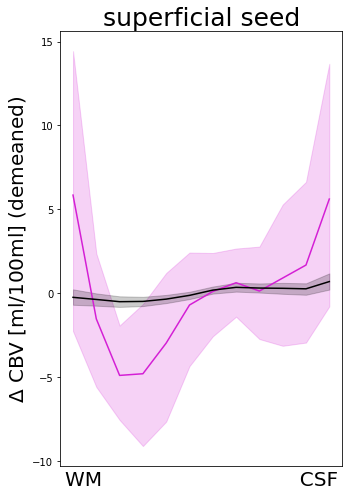

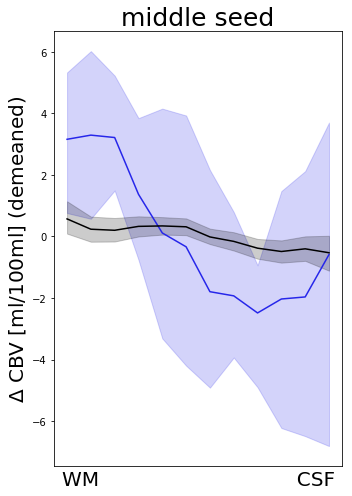

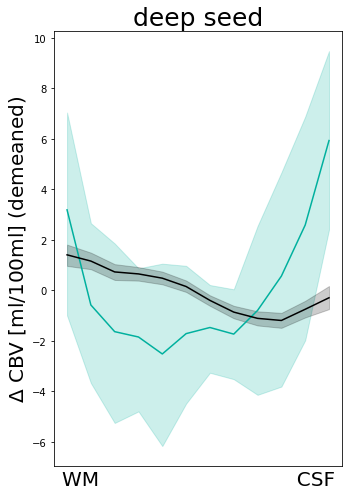

In [733]:
colors=['#00B09E', '#2626EA','#D41FD5']
depths = ['01','02','03']
depths.reverse()
colors.reverse()
seed_labels = ['superficial','middle','deep']


for depth,seed_label,color in zip(depths,seed_labels,colors):
    fig, ax = plt.subplots(tight_layout=True,figsize=(5,7))
    
    plt.title('%s seed'%(seed_label), fontsize=25)


    sns.lineplot(ax=ax, data = sub_data.loc[(sub_data['subject']=='sub-02')&(sub_data['depth']==depth)&(sub_data['modality']=='VASO')], x='layer', y='layer_val',color=color)
    sns.lineplot(ax=ax, data = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['modality']=='VASO')], x='layer', y='layer_val',color='black')

    ax.set_ylabel(r'$\Delta$ CBV [ml/100ml] (demeaned)',fontsize=20)

    plt.xlabel("WM                               CSF",fontsize=20)

    plt.xticks([],[])

## Statistical Testing

### connectivity between ROIs


#### Anova

In [442]:
from statsmodels.stats.anova import AnovaRM

for modality in modalities:
    print(modality)
    
    for depth,seed_label,color in zip(depths,seed_labels,colors):
        data2 = sub_data.loc[(sub_data['depth']==depth)&(sub_data['modality']==modality)]

        results = AnovaRM(data=data2, depvar='layer_val', subject='subject', within=['layer'],aggregate_func='mean').fit()
        print(results)

BOLD
                Anova
      F Value  Num DF  Den DF  Pr > F
-------------------------------------
layer  6.8724 11.0000 110.0000 0.0000

                Anova
      F Value  Num DF  Den DF  Pr > F
-------------------------------------
layer  1.3780 11.0000 110.0000 0.1933

                Anova
      F Value  Num DF  Den DF  Pr > F
-------------------------------------
layer  2.3799 11.0000 110.0000 0.0111

VASO
                Anova
      F Value  Num DF  Den DF  Pr > F
-------------------------------------
layer  2.0058 11.0000 110.0000 0.0343

                Anova
      F Value  Num DF  Den DF  Pr > F
-------------------------------------
layer  0.1669 11.0000 110.0000 0.9988

                Anova
      F Value  Num DF  Den DF  Pr > F
-------------------------------------
layer  2.7431 11.0000 110.0000 0.0036



### T-tests

### assumptions

In [447]:

for modality in modalities:
    print(modality)
    
    for depth,seed_label,color in zip(depths,seed_labels,colors):

        for layer in sub_data['layer'].unique():
        #     fig, axs = plt.subplots(1, 2)

            data1 = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['layer']==layer)&(permutSub_data['modality']==modality)]['layer_val']
            data2 = sub_data.loc[(sub_data['depth']==depth)&(sub_data['layer']==layer)&(sub_data['modality']==modality)]['layer_val']

        #     sns.histplot(ax = axs[0], x= data1, kde=True)
        #     sns.histplot(ax = axs[1], x= data2, kde=True)

        #     plt.suptitle(f'Layer {layer}')


        #     plt.show()
            stat = stats.ttest_ind(data1, data2)[1]
            if stat < 0.05:
                print(f'{seed_label} Layer {layer}')
                print(f'Corrected P value: {stat}')

BOLD
superficial Layer 1
Corrected P value: 0.032929159948486816
superficial Layer 2
Corrected P value: 0.0002063819275378789
superficial Layer 3
Corrected P value: 0.0035992502429967833
superficial Layer 12
Corrected P value: 0.020809535745448592
middle Layer 1
Corrected P value: 0.03226029297620281
middle Layer 10
Corrected P value: 0.03176932686965328
deep Layer 1
Corrected P value: 3.3996077390584426e-06
deep Layer 2
Corrected P value: 0.03183874742892269
deep Layer 10
Corrected P value: 0.028732159734665523
deep Layer 11
Corrected P value: 0.01976624028312455
VASO
deep Layer 1
Corrected P value: 0.0005781503734688799
deep Layer 2
Corrected P value: 0.042610843518687685
deep Layer 5
Corrected P value: 0.04741989138016671
deep Layer 6
Corrected P value: 0.047578526797954726
deep Layer 12
Corrected P value: 0.04720377783314745


### Connectivity between columns

#### ANOVA

In [734]:
from statsmodels.stats.anova import AnovaRM

for modality in ['VASO']:
    print(modality)
    
    for depth,seed_label,color in zip(depths,seed_labels,colors):
        data2 = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['modality']==modality)]

        results = AnovaRM(data=data2, depvar='layer_val', subject='subject', within=['layer'], aggregate_func='mean').fit()
        print(results)

VASO
               Anova
      F Value  Num DF Den DF Pr > F
-----------------------------------
layer  0.0000 11.0000 0.0000    nan

               Anova
      F Value  Num DF Den DF Pr > F
-----------------------------------
layer  0.0000 11.0000 0.0000    nan

               Anova
      F Value  Num DF Den DF Pr > F
-----------------------------------
layer  0.0000 11.0000 0.0000    nan



/home/sebastian/anaconda3/lib/python3.7/site-packages/statsmodels/stats/anova.py:600: RuntimeWarning:

divide by zero encountered in double_scalars



VASO
deep Layer 5
Corrected P value: 0.026398464226957616
deep Layer 6
Corrected P value: 0.027411579187338615


/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



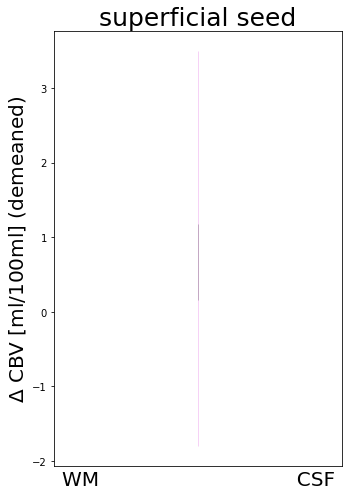

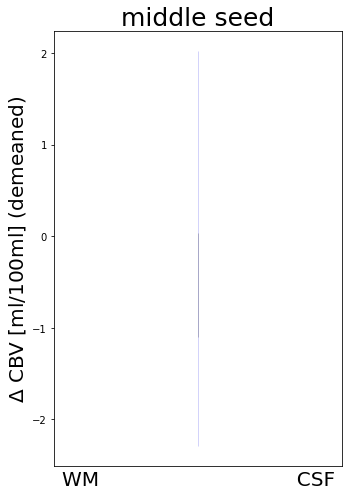

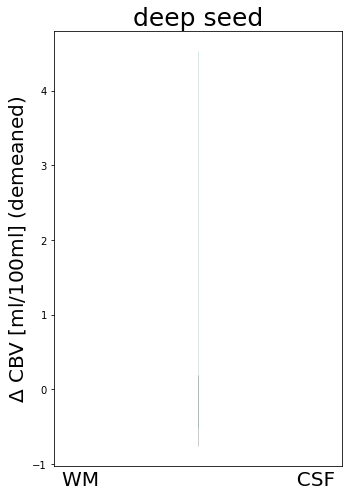

In [745]:

for modality in ['VASO']:
    print(modality)
    
    for depth,seed_label,color in zip(depths,seed_labels,colors):

        for layer in sub_data['layer'].unique():
            
            


            data1 = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['layer']==layer)&(permutSub_data['modality']==modality)]['layer_val']
            data2 = sub_data.loc[(sub_data['depth']==depth)&(sub_data['layer']==layer)&(sub_data['modality']==modality)]['layer_val']

            
            
            
            
            
            stat = stats.ttest_ind(data1, data2)[1]
            if stat < 0.05:
                print(f'{seed_label} Layer {layer}')
                print(f'Corrected P value: {stat}')
                
                
        fig, ax = plt.subplots(tight_layout=True,figsize=(5,7))

        plt.title('%s seed'%(seed_label), fontsize=25)


        sns.lineplot(ax=ax, data = sub_data.loc[(sub_data['depth']==depth)&(sub_data['layer']==layer)&(sub_data['modality']==modality)], x='layer', y='layer_val',color=color)
        sns.lineplot(ax=ax, data = permutSub_data.loc[(permutSub_data['depth']==depth)&(permutSub_data['layer']==layer)&(permutSub_data['modality']==modality)], x='layer', y='layer_val',color='black')

        ax.set_ylabel(r'$\Delta$ CBV [ml/100ml] (demeaned)',fontsize=20)

        plt.xlabel("WM                               CSF",fontsize=20)

        plt.xticks([],[])

make single column masks

In [501]:
for sub in ['sub-02']:
    
    os.system(f'mkdir {root}/derivatives/{sub}/func/deleteMe')
    
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
    colArr = nb.load(colFile).get_fdata()
    colNrs = np.unique(colArr)[1:]
    
    
    for colNr in colNrs:
        col = (colArr == colNr).astype(int)
        
        ni_img = nb.Nifti1Image(col, nb.load(colFile).affine)
        nb.save(ni_img, f'{root}/derivatives/{sub}/func/deleteMe/col{"%03d" % (int(colNr),)}.nii')
    
    

sub-02_ses-003_task-restBA3b_run-001


In [514]:
for sub in ['sub-02']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    
    
    # find number of columns
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
    colArr = nb.load(colFile).get_fdata()
    colNrs = np.unique(colArr)[1:]
    
    for n in range(nrPermutations):             
                       
        combined = np.zeros((colArr.shape))
        
        for number in range(3):
            col = nb.load(f'{root}/derivatives/{sub}/func/deleteMe/col{"%03d" % (int( permutations[n,int(number)]),)}.nii').get_fdata()
            combined = np.add(combined,col)
                          
        ni_img = nb.Nifti1Image(combined, nb.load(colFile).affine)
        nb.save(ni_img, f'{root}/derivatives/{sub}/func/deleteMe/iteration{"%03d" % (int(n+1),)}.nii')
                
                
        

sub-02_ses-003_task-restBA3b_run-001


In [515]:
box

(slice(214, 496, None), slice(24, 253, None), slice(3, 15, None))

In [557]:
for sub in ['sub-02']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    
    
    
    # find number of columns
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
    colArr = nb.load(colFile).get_fdata()
    colNrs = np.unique(colArr)[1:]
    
    for iteration in range(nrPermutations):             
                       
        cols = nb.load(f'{root}/derivatives/{sub}/func/deleteMe/iteration{"%03d" % (iteration+1,)}.nii').get_fdata()
        box = find_roi_box(cols)
        cols = nb.load(f'{root}/derivatives/{sub}/func/deleteMe/iteration{"%03d" % (iteration+1,)}.nii').get_fdata()[box[0], box[1], box[2]]
        idx = cols == 1               
                       
        for modality in modalities:
                       
            data = nb.load(f'{root}/derivatives/{sub}/func/{base}_BOLD.nii.gz')
            tr = 1.9295
            header = data.header
            zooms = header.get_zooms()[:3] + (tr,)
            header.set_zooms(zooms)

                       
            timepoints = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz').get_fdata().shape[-1]
            
            data = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_1000_scaled.nii')
            dataArr = data.get_fdata()[box[0], box[1], box[2]][idx]
            
            newData = np.zeros((dataArr.shape[0],1,1,timepoints-1))
            
            affine = data.affine


            for n in range(0, timepoints-1):
                vol = nb.load(f'{root}/derivatives/{sub}/func/scaledVolumes/{base}_{modality}_vol_{n+1000}_scaled.nii')
                volArr = vol.get_fdata()[box[0], box[1], box[2]][idx]
                       
                newData[:,0,0,n] = volArr

            ni_img = nb.Nifti1Image(newData, affine, header)
            
            newFile = f'{root}/derivatives/{sub}/func/deleteMe/iteration{"%03d" % (iteration+1,)}_{modality}_scaled.nii'     
            
#             set_tr(ni_img, 1.9295)
            
                       
            nb.save(ni_img, newFile)
                       
#             set_tr(nb.load(newFile), 1.9295)
            
#             os.system(f'3drefit -TR 1.9295 {newFile}')

                
                
        

sub-02_ses-003_task-restBA3b_run-001


In [550]:
permutations

array([[453., 117., 150.],
       [494., 485., 185.],
       [ 67., 153., 169.],
       [299., 499., 205.],
       [301., 324., 470.],
       [298., 156., 374.],
       [473., 119., 365.],
       [119., 407., 159.],
       [125., 480., 429.],
       [106., 367., 110.]])

In [556]:
for n in range(1):             

    for number in range(3):
        print(f'{root}/derivatives/{sub}/func/timecourses/{base}_VASO_col{"%03d" % (int( permutations[n,int(number)]),)}_03layers_layer01_timecourse.txt')


/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/timecourses/sub-02_ses-003_task-restBA3b_run-001_VASO_col453_03layers_layer01_timecourse.txt
/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/timecourses/sub-02_ses-003_task-restBA3b_run-001_VASO_col117_03layers_layer01_timecourse.txt
/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-02/func/timecourses/sub-02_ses-003_task-restBA3b_run-001_VASO_col150_03layers_layer01_timecourse.txt


In [584]:
testsub_list=[]
testseed_rois=[]
testread_rois=[]
testlayer_val=[]
testlayerNr=[]
testseedDepths_list=[]
testmodalityList = []



for sub in ['sub-02']:
    
    run = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-restBA3b_run-00*_cbv.nii.gz'))[0]
    base = os.path.basename(run).rsplit('.', 2)[0][:-4]
    print(base)
    
    colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
    colArr = nb.load(colFile).get_fdata()

    
    layFile = f'{root}/derivatives/{sub}/anat/{sub}_12_layers_equivol.nii'
    layArr = nb.load(layFile).get_fdata()
    
    for iteration in range(1):             
        cols = nb.load(f'{root}/derivatives/{sub}/func/deleteMe/iteration{str(iteration+1).zfill(3)}.nii').get_fdata()
        box = find_roi_box(cols)
        
        cols = nb.load(f'{root}/derivatives/{sub}/func/deleteMe/iteration{str(iteration+1).zfill(3)}.nii').get_fdata()[box[0], box[1], box[2]]
        idx = cols == 1
        
        
        colFile = glob.glob(f'{root}/derivatives/{sub}/anat/findColSize/{sub}_columns*.nii')[0]
        colArr = nb.load(colFile).get_fdata()[box[0], box[1], box[2]] 

    
        layFile = f'{root}/derivatives/{sub}/anat/{sub}_12_layers_equivol.nii'
        layArr = nb.load(layFile).get_fdata()[box[0], box[1], box[2]] 
                       

        colArr = colArr[idx]      
        layArr = layArr[idx]
        
        
        columns = permutations[iteration,:]
        
        for i, seedColumn in enumerate(columns):
            print(f'seedCol: {seedColumn}')
            
            nonseeds = columns.tolist().copy()
            nonseeds.remove(seedColumn)
 


            resultsMap = nb.load(f'{root}/derivatives/sub-02/func/deleteMe/test.feat/stats/pe{i+1}.nii.gz').get_fdata()
            print(f'map: pe{i+1}')
            for readROI in nonseeds:
                print(f'read from: {readROI}')

                roi = nb.load(layFile).get_fdata()[box[0], box[1], box[2]][idx]

                profile = []

                for layer in np.unique(roi)[1:]:

                    layerRoi = roi == layer

                    mask_mean = np.mean(resultsMap[layerRoi])
                    profile.append(mask_mean)

                arr = np.array(profile)
                arr = arr-np.mean(arr)

                for n, val in enumerate(arr):                
                    testlayer_val.append(float(np.copy(val)))
                    testlayerNr.append(n+1)
                    testseed_rois.append(str(seedColumn))
                    testread_rois.append(str(readROI))
                    testsub_list.append(sub)
#                     testseedDepths_list.append("%02d" % (int(seedLayer),))
#                     testmodalityList.append(modality)

sub-02_ses-003_task-restBA3b_run-001
seedCol: 453.0
map: pe1
read from: 117.0
read from: 150.0
seedCol: 117.0
map: pe2
read from: 453.0
read from: 150.0
seedCol: 150.0
map: pe3
read from: 453.0
read from: 117.0


In [581]:
testSub_data = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val'])
testSub_data['subject']=testsub_list
testSub_data['seed_roi']=testseed_rois
testSub_data['read_roi']=testread_rois
testSub_data['layer']=testlayerNr
testSub_data['layer_val']=testlayer_val


([], <a list of 0 Text xticklabel objects>)

/home/sebastian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



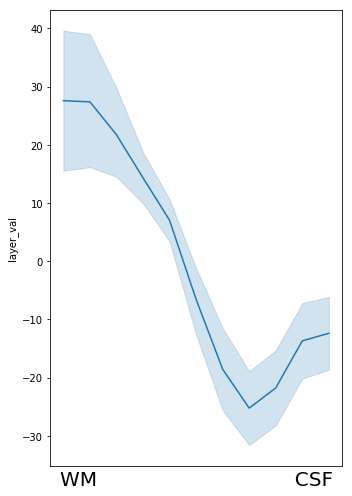

In [582]:
fig, ax = plt.subplots(tight_layout=True,figsize=(5,7))



sns.lineplot(ax=ax, data = testSub_data, x='layer', y='layer_val')


plt.xlabel("WM                               CSF",fontsize=20)

plt.xticks([],[])

In [479]:
for sub in ['sub-02']:
    
    
    for modality in ['BOLD', 'VASO']:
        print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-rest*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
                    
            for col in ['001', '287','245']:
                for layer in ['01','02','03']:
                    text = np.loadtxt(f'{root}/derivatives/sub-02/func/timecourses/{base}_{modality}_col{col}_layer{layer}_timecourse.txt')
                    print(text.shape)
                    
#                     np.savetxt(f'{root}/derivatives/sub-02/func/timecourses/{base}_{modality}_col{col}_layer{layer}_timecourse.txt', text[:-1], delimiter='/n', fmt='%1.4f')

                    

BOLD
sub-02_ses-003_task-restBA3b_run-001
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)
VASO
sub-02_ses-003_task-restBA3b_run-001
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)
(651,)


In [ ]:
from numpy import array
conditions = {
    'seed': array([1,0])}



for n in range(nrPermutations):
    
    columns = random.choices(columnNrs, k=3)
    
    print(columns)


    sub_list=[]
    seed_rois=[]
    read_rois=[]
    layer_val=[]
    layerNr=[]
    seedDepths_list=[]


    for sub in ['sub-15']:
        print(sub)
        
        
        layerData = nb.load(f'{root}/derivatives/sub-15/anat/sub-15_3_layers_equivol.nii')
        layData =layNii.get_fdata()
        
        
        roi = nb.load(f'{root}/derivatives/sub-15/anat/findColSize/sub-15_columns300.nii').get_fdata()
        allCols = np.zeros(roi.shape)


        for column in columns:
            
            col = (colData == column).astype(int)
            allCols = np.add(allCols, roi)

        allCols = (allCols>0).astype(int)


        box = find_roi_box(allCols)

        for seedlayer in range(1,4):

            for seedROI in columns:
                print(f'seed : {seedROI}')
                nonseeds = columns.copy()
                nonseeds.remove(seedROI)

                timecourse = np.loadtxt(f'{root}/derivatives/{sub}/func/timecourses/{sub}_ses-001_task-restBA3b_run-001_{modality}_col{int(column):03d}_layer{seedlayer:02d}_timecourse.txt', delimiter='\n')[:-1]
                print(timecourse.shape[0])

                frametimes = np.linspace(0, (timecourse.shape[0] - 1) * 1.929500, timecourse.shape[0])

                design_matrix = make_first_level_design_matrix(frametimes, hrf_model='spm',drift_model=None,
                                                           add_regs=timecourse,
                                                           add_reg_names=["seed"])

                fmri_glm = FirstLevelModel(mask_img=False, standardize=True)

                fmri_glm = fmri_glm.fit(f'{root}/derivatives/{sub}/func/{sub}_ses-001_task-restBA3b_run-001_{modality}_scaled.nii', design_matrices=design_matrix)

                statMap = fmri_glm.compute_contrast(conditions['seed'], output_type='effect_size').get_fdata()


                for readROI in nonseeds:
                    print(f'read from: {readROI}')
                    
                    roiTmp = (roi == column).astype(int)[box[0], box[1], box[2]]
                    
                    
                    profile = []

                    for layer in np.unique(layData)[1:]:

                        layerRoi = (layData == layer).astype(int)[box[0], box[1], box[2]]
                        
                        intersect = np.multiply(layerRoi, roiTmp)

                        mask_mean = np.mean(statMap[intersect])
                        profile.append(mask_mean)

                    arr = np.array(profile)
                    arr = arr-np.mean(arr)

                    for n, val in enumerate(arr):                
                        layer_val.append(float(np.copy(val)))
                        layerNr.append(n+1)
                        seed_rois.append(str(seedROI))
                        read_rois.append(str(readROI))
                        sub_list.append(sub)
                        seedDepths_list.append("%02d" % (int(seedlayer),))


    permuted_columns = pd.DataFrame(columns=['subject','seed_roi','read_roi','layer','layer_val','depth'])
    permuted_columns['subject']=sub_list
    permuted_columns['seed_roi']=seed_rois
    permuted_columns['read_roi']=read_rois
    permuted_columns['layer']=layerNr
    permuted_columns['layer_val']=layer_val
    permuted_columns['depth']=seedDepths_list